In [1]:
import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np; np.set_printoptions(threshold=sys.maxsize)

DUD_VALUE= 123
TOTAL_ROWS= 2228278
INPUT_ROWS_LIMIT= TOTAL_ROWS # TOTAL_ROWS
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATION_ID= 117
SECS_IN_5MIN= 300
DATAPOINTS_PER_DAY= 288
DAYS_OF_WEEK= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # yes, I consider Monday to be the '0'/start of the week
STARTING_DAY= 4
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1]
TOTAL_DAYS= 91
OPEN_HOURS= 18 # want to change this to 18 i.e. excluding 1, 2, 3, and 4 am
MAX_DISPLAYED_STATIONS= 1
MAX_DISPLAYED_DAYS= 10
MAX_TIME= int((datetime.datetime(2020,4,2,0,0) - datetime.datetime(2020,1,1,0,0)).total_seconds() / SECS_IN_5MIN)
START_TIME= int((datetime.datetime(2020, 1, 1, 4, 0) - datetime.datetime(2020, 1, 1, 0, 0)).total_seconds() / SECS_IN_5MIN) # bike sharing starts at 4am at earliest
MAX_MISSING_STATIONS= 10

class DataDay: # ideally this would be nested in the Station class
    def __init__(self, index):
        self.index= index
        self.day_of_week= DUD_VALUE
        self.day_since_epoch= DUD_VALUE
        
        self.daily_epoch_time= np.full(DATAPOINTS_PER_DAY, DUD_VALUE, dtype=np.int)
        self.epoch_time= np.full(DATAPOINTS_PER_DAY, DUD_VALUE, dtype=np.int)
        self.bikes= np.full(DATAPOINTS_PER_DAY, DUD_VALUE, dtype=np.int)
        self.percent_bikes= np.full(DATAPOINTS_PER_DAY, DUD_VALUE, dtype=np.float)

    def populate(self, daily_epoch_time, epoch_time, bikes, percent_bikes):
        self.day_of_week= (STARTING_DAY + int(epoch_time / DATAPOINTS_PER_DAY)) % len(DAYS_OF_WEEK)
        self.day_since_epoch= 1 + int(epoch_time / DATAPOINTS_PER_DAY)
        self.daily_epoch_time[daily_epoch_time]= daily_epoch_time
        self.epoch_time[daily_epoch_time]= epoch_time
        self.bikes[daily_epoch_time]= bikes
        self.percent_bikes[daily_epoch_time]= percent_bikes

class Station:
    def __init__(self, index):
        self.index= index
        self.name= DUD_VALUE
        self.bike_capacity= DUD_VALUE
        self.address= DUD_VALUE
        self.latitude= DUD_VALUE
        self.longitude= DUD_VALUE
        self.data_days= [DataDay(i) for i in range(1, TOTAL_DAYS + 3)] # Admitedly, I don't even know exactly why this has to be +3
    
    def populate_consts(self, name, bike_capacity, address, latitude, longitude):
        self.name= name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

def get_station_id(name):
    try:
        index= [x.name for x in stations].index(name)
    except ValueError:
        index= -1
    return index

In [2]:
total_capacity= 0 # not in use currently
index= []; daily_epoch_time= []; epoch_time= []; percent_bikes= [];
stations= [Station(i) for i in range(1, MAX_STATION_ID + 1)] # note: MAX_STATION_ID + 1 is not included in the range
indices_to_populate= list(range(1, MAX_STATION_ID + 1))
for index in MISSING_STATIONS:
    indices_to_populate.remove(index)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip data header
    current_index= 0
    try:
        while len(indices_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_index: # this 'if' is just for performance
                continue
            current_index= int(row[0])
            if current_index in indices_to_populate:
                stations[current_index - 2].populate_consts(row[3], row[4], row[8], row[9], row[10])
                indices_to_populate.remove(current_index)
                total_capacity+= int(row[4])
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip data header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            try:
                epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(2020,1,1,0,0)).total_seconds() / (SECS_IN_5MIN + 1)) # the unit of epoch_time is 5-minutes # the + 1 is a means to decrement the results
                stations[int(row[0]) - 1].data_days[int(epoch_time / DATAPOINTS_PER_DAY) + 1].populate( \
                    int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / (SECS_IN_5MIN + 1)), \
                    epoch_time, \
                    int(row[6]), \
                    float("{:.3f}".format(float(row[6]) / float(row[4]))))
            except IndexError as e:
                print("\nTRIED: ", epoch_time, ' / ', DATAPOINTS_PER_DAY, ' = ', int(epoch_time / DATAPOINTS_PER_DAY))
                print(row[1])
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))

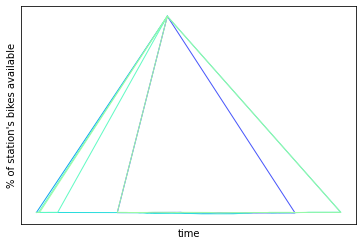

In [3]:
def station_graph(index):
    if MAX_DISPLAYED_DAYS < TOTAL_DAYS:
        colors= cm.rainbow(np.linspace(0, 1, MAX_DISPLAYED_DAYS))
    else:
        colors= cm.rainbow(np.linspace(0, 1, TOTAL_DAYS))

    for (day_i, day), c in zip(enumerate(stations[index].data_days), colors): # use day_i + 1 to access days because day 0 is empty but kept so that the day's date works as an array index too
        if day_i >= MAX_DISPLAYED_DAYS:
            break
        #plt.scatter(station.daily_epoch_time, station.percent_bikes, 1, marker="*", color= c, linewidth=0.0001)
        plt.plot(day.daily_epoch_time, day.percent_bikes, 1, color= c, linewidth=1)
    plt.ylabel('% of station\'s bikes available')
    plt.xlabel('time')
    plt.xticks(())
    plt.yticks(())

    plt.show()

    #plt.scatter(daily_epoch_time, percent_bikes,  color='black')

station_graph(get_station_id('PORTOBELLO ROAD'))

In [37]:
# Approach 01 - Data Prep

time= int((datetime.datetime(2020, 1, 1, 6, 25) - datetime.datetime(2020, 1, 1, 0, 0)).total_seconds() / SECS_IN_5MIN)
station_index_decrement= 1 # this is a varying offset for the indexing of stations that accounts for missing stations that are being ignored
# np.full(DATAPOINTS_PER_DAY, DUD_VALUE, dtype=np.int)
row_vol= MAX_TIME - time - START_TIME * TOTAL_DAYS
fullness= np.full((row_vol, MAX_STATION_ID - len(MISSING_STATIONS)), DUD_VALUE, dtype=np.float)
bikes_changes_past5= np.full((row_vol, MAX_STATION_ID - len(MISSING_STATIONS)), DUD_VALUE, dtype=np.int)
bikes_changes_past15= np.full((row_vol, MAX_STATION_ID - len(MISSING_STATIONS)), DUD_VALUE, dtype=np.int)
bikes_changes_past45= np.full((row_vol, MAX_STATION_ID - len(MISSING_STATIONS)), DUD_VALUE, dtype=np.int)
day_of_week= np.full((row_vol, len(DAYS_OF_WEEK)), DUD_VALUE, dtype=np.int)
hour_of_day= np.full((row_vol, OPEN_HOURS), DUD_VALUE, dtype=np.float)

rejected_days= 0
for epoch_day_i in range(TOTAL_DAYS):
    for station in stations:
        if station.index == 1:
            station_index_decrement= 1
        if station.index in MISSING_STATIONS:
            station_index_decrement+= 1
            continue
        block= station.data_days[epoch_day_i].percent_bikes[START_TIME:DATAPOINTS_PER_DAY]
        block= np.reshape(block, (DATAPOINTS_PER_DAY - START_TIME, 1))
        x= epoch_day_i * (DATAPOINTS_PER_DAY - START_TIME)
        print("station.index: ",station.index)
        print("station_index_decrement: ",station_index_decrement)
        y= station.index - station_index_decrement
        fullness[x:x + block.shape[0], y:y + block.shape[1]]= block
        #if num in arr:
            
        block= station.data_days[epoch_day_i].bikes[START_TIME:DATAPOINTS_PER_DAY]
        block_5minchange= np.zeros(DATAPOINTS_PER_DAY - START_TIME, dtype=np.int)
        block_15minchange= np.zeros(DATAPOINTS_PER_DAY - START_TIME, dtype=np.int)
        block_45minchange= np.zeros(DATAPOINTS_PER_DAY - START_TIME, dtype=np.int)
        for block_i in range(len(block)):
            try:
                block_5minchange[block_i]= block[block_i] - block[block_i - 1]
                block_15minchange[block_i]= block[block_i] - block[block_i - 3]
                block_45minchange[block_i]= block[block_i] - block[block_i - 9]
            except IndexError:
                print("IndexError")
                pass
        block= np.reshape(block, (DATAPOINTS_PER_DAY - START_TIME, 1))
        block_5minchange= np.reshape(block_5minchange, (DATAPOINTS_PER_DAY - START_TIME, 1))
        block_15minchange= np.reshape(block_15minchange, (DATAPOINTS_PER_DAY - START_TIME, 1))
        block_45minchange= np.reshape(block_45minchange, (DATAPOINTS_PER_DAY - START_TIME, 1))
        #print("x: ", x)
        #print("y: ", y)
        bikes_changes_past5[x:x + block.shape[0], y:y + block.shape[1]]= block_5minchange
        bikes_changes_past15[x:x + block.shape[0], y:y + block.shape[1]]= block_15minchange
        bikes_changes_past45[x:x + block.shape[0], y:y + block.shape[1]]= block_45minchange
        
    block= np.zeros((DATAPOINTS_PER_DAY - START_TIME, len(DAYS_OF_WEEK)), dtype=np.int)
    day= (epoch_day_i + 2) % len(DAYS_OF_WEEK) # Jan 1st is a wednesday, so need to add 2 to make it so
    for block_i, sub_arr in enumerate(block):
        block[block_i][day]= 1
    y= 0
    day_of_week[x:x + block.shape[0], y:y + block.shape[1]]= block
    
    block= np.zeros((DATAPOINTS_PER_DAY - START_TIME, OPEN_HOURS), dtype=np.float)
    for time_i in range(OPEN_HOURS):
        hour= float("{:.3f}".format(time_i / 12))
        block[time_i][int(hour) - 1]= 1 - (hour % 1)
        block[time_i][int(hour)]= hour % 1
    hour_of_day[x:x + block.shape[0], y:y + block.shape[1]]= block



station.index:  2
station_index_decrement:  2
station.index:  3
station_index_decrement:  2
station.index:  4
station_index_decrement:  2
station.index:  5
station_index_decrement:  2
station.index:  6
station_index_decrement:  2
station.index:  7
station_index_decrement:  2
station.index:  8
station_index_decrement:  2
station.index:  9
station_index_decrement:  2
station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.index:  12
station_index_decrement:  2
station.index:  13
station_index_decrement:  2
station.index:  15
station_index_decrement:  3
station.index:  16
station_index_decrement:  3
station.index:  17
station_index_decrement:  3
station.index:  18
station_index_decrement:  3
station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
st

station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index:  88
station_index_decrement:  8
station.index:  89
station_index_decrement:  8
station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.i

station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index

station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
station.index:  107
station_index_decrement:  8
station.index:  108
station_index_decrement:  8
station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
station.index:  111
station_index_decrement:  8
station.index:  112
station_index_decrement:  8
station.index:  113
station_index_decrement:  8
station.index:  114
station_index_decrement:  8
station.index:  115
station_index_decrement:  8
station.index:  2
station_index_decrement:  2
station.index:  3
station_index_decrement:  2
station.index:  4
station_index_decrement:  2
station.index:  5
station_index_decrement:  2
station.index:  6
station_index_decrement:  2
station.index:  7
station_index_decrement:  2
station.index:  8
station_index_decrement:  2
station.index:  9
station_index_decrement:  2
station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.in

station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index:  88
station_index_decrement:  8
station.index:  89
station_index_decrement:  8
station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
statio

station.index:  49
station_index_decrement:  6
station.index:  50
station_index_decrement:  6
station.index:  51
station_index_decrement:  6
station.index:  52
station_index_decrement:  6
station.index:  53
station_index_decrement:  6
station.index:  54
station_index_decrement:  6
station.index:  55
station_index_decrement:  6
station.index:  56
station_index_decrement:  6
station.index:  57
station_index_decrement:  6
station.index:  58
station_index_decrement:  6
station.index:  59
station_index_decrement:  6
station.index:  61
station_index_decrement:  7
station.index:  62
station_index_decrement:  7
station.index:  63
station_index_decrement:  7
station.index:  64
station_index_decrement:  7
station.index:  65
station_index_decrement:  7
station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index

station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
station.index:  107
station_index_decrement:  8
station.index:  108
station_index_decrement:  8
station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
station.index:  111
station_index_decrement:  8
station.index:  112


station.index:  74
station_index_decrement:  8
station.index:  75
station_index_decrement:  8
station.index:  76
station_index_decrement:  8
station.index:  77
station_index_decrement:  8
station.index:  78
station_index_decrement:  8
station.index:  79
station_index_decrement:  8
station.index:  80
station_index_decrement:  8
station.index:  81
station_index_decrement:  8
station.index:  82
station_index_decrement:  8
station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index:  88
station_index_decrement:  8
station.index:  89
station_index_decrement:  8
station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index

station.index:  6
station_index_decrement:  2
station.index:  7
station_index_decrement:  2
station.index:  8
station_index_decrement:  2
station.index:  9
station_index_decrement:  2
station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.index:  12
station_index_decrement:  2
station.index:  13
station_index_decrement:  2
station.index:  15
station_index_decrement:  3
station.index:  16
station_index_decrement:  3
station.index:  17
station_index_decrement:  3
station.index:  18
station_index_decrement:  3
station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  2

station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
station.index:  107
station_index_decrement:  8
station.index:  108
station_index_decrement:  8
station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
st

station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index:  72
station_index_decrement:  8
station.index:  73
station_index_decrement:  8
station.index:  74
station_index_decrement:  8
station.index:  75
station_index_decrement:  8
station.index:  76
station_index_decrement:  8
station.index:  77
station_index_decrement:  8
station.index:  78
station_index_decrement:  8
station.index:  79
station_index_decrement:  8
station.index:  80
station_index_decrement:  8
station.index:  81
station_index_decrement:  8
station.index:  82
station_index_decrement:  8
station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index:  88
station_index_decrement:  8
station.index:  89
station_index_decrement:  8
station.index:  90
station_index

station.index:  48
station_index_decrement:  6
station.index:  49
station_index_decrement:  6
station.index:  50
station_index_decrement:  6
station.index:  51
station_index_decrement:  6
station.index:  52
station_index_decrement:  6
station.index:  53
station_index_decrement:  6
station.index:  54
station_index_decrement:  6
station.index:  55
station_index_decrement:  6
station.index:  56
station_index_decrement:  6
station.index:  57
station_index_decrement:  6
station.index:  58
station_index_decrement:  6
station.index:  59
station_index_decrement:  6
station.index:  61
station_index_decrement:  7
station.index:  62
station_index_decrement:  7
station.index:  63
station_index_decrement:  7
station.index:  64
station_index_decrement:  7
station.index:  65
station_index_decrement:  7
station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index

station.index:  18
station_index_decrement:  3
station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index

station.index:  110
station_index_decrement:  8
station.index:  111
station_index_decrement:  8
station.index:  112
station_index_decrement:  8
station.index:  113
station_index_decrement:  8
station.index:  114
station_index_decrement:  8
station.index:  115
station_index_decrement:  8
station.index:  2
station_index_decrement:  2
station.index:  3
station_index_decrement:  2
station.index:  4
station_index_decrement:  2
station.index:  5
station_index_decrement:  2
station.index:  6
station_index_decrement:  2
station.index:  7
station_index_decrement:  2
station.index:  8
station_index_decrement:  2
station.index:  9
station_index_decrement:  2
station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.index:  12
station_index_decrement:  2
station.index:  13
station_index_decrement:  2
station.index:  15
station_index_decrement:  3
station.index:  16
station_index_decrement:  3
station.index:  17
station_index_decrement:  3
station.index: 

station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index:  72
station_index_decrement:  8
station.index:  73
station_index_decrement:  8
station.index:  74
station_index_decrement:  8
station.index:  75
station_index_decrement:  8
station.index:  76
station_index_decrement:  8
station.index:  77
station_index_decrement:  8
station.index:  78
station_index_decrement:  8
station.index:  79
station_index_decrement:  8
station.index:  80
station_index_decrement:  8
station.index:  81
station_index_decrement:  8
station.index:  82
station_index_decrement:  8
station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index

station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index

station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index:  42
station_index_decrement:  5
station.index:  43
station_index_decrement:  5
station.index:  44
station_index_decrement:  5
station.index:  45
station_index_decrement:  5
station.index:  47
station_index_decrement:  6
station.index:  48
station_index_decrement:  6
station.index:  49
station_index_decrement:  6
station.index:  50
station_index_decrement:  6
station.index:  51
station_index_decrement:  6
station.index:  52
station_index_decrement:  6
station.index:  53
station_index_decrement:  6
station.index:  54
station_index_decrement:  6
station.index:  55
station_index_decrement:  6
station.index:  56
station_index_decrement:  6
station.index:  57
station_index_decrement:  6
station.index:  58
station_index_decrement:  6
station.index

station.index:  42
station_index_decrement:  5
station.index:  43
station_index_decrement:  5
station.index:  44
station_index_decrement:  5
station.index:  45
station_index_decrement:  5
station.index:  47
station_index_decrement:  6
station.index:  48
station_index_decrement:  6
station.index:  49
station_index_decrement:  6
station.index:  50
station_index_decrement:  6
station.index:  51
station_index_decrement:  6
station.index:  52
station_index_decrement:  6
station.index:  53
station_index_decrement:  6
station.index:  54
station_index_decrement:  6
station.index:  55
station_index_decrement:  6
station.index:  56
station_index_decrement:  6
station.index:  57
station_index_decrement:  6
station.index:  58
station_index_decrement:  6
station.index:  59
station_index_decrement:  6
station.index:  61
station_index_decrement:  7
station.index:  62
station_index_decrement:  7
station.index:  63
station_index_decrement:  7
station.index:  64
station_index_decrement:  7
station.index

station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index

station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
station.index:  111
station_index_decrement:  8
station.index:  112
station_index_decrement:  8
station.index:  113
station_index_decrement:  8
station.index:  114
station_index_decrement:  8
station.index:  115
station_index_decrement:  8
station.index:  2
station_index_decrement:  2
station.index:  3
station_index_decrement:  2
station.index:  4
station_index_decrement:  2
station.index:  5
station_index_decrement:  2
station.index:  6
station_index_decrement:  2
station.index:  7
station_index_decrement:  2
station.index:  8
station_index_decrement:  2
station.index:  9
station_index_decrement:  2
station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.index:  12
station_index_decrement:  2
station.index:  13
station_index_decrement:  2
station.index:  15
station_index_decrement:  3
station.index:  16
station_index_decrement:  3
station.index:

station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index:  42
station_index_decrement:  5
station.index:  43
station_index_decrement:  5
station.index:  44
station_index_decrement:  5
station.index:  45
station_index_decrement:  5
station.index:  47
station_index_decrement:  6
station.index

station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index:  42
station_index_decrement:  5
station.index

station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.index:  12
station_index_decrement:  2
station.index:  13
station_index_decrement:  2
station.index:  15
station_index_decrement:  3
station.index:  16
station_index_decrement:  3
station.index:  17
station_index_decrement:  3
station.index:  18
station_index_decrement:  3
station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index

station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index:  72
station_index_decrement:  8
station.index:  73
station_index_decrement:  8
station.index:  74
station_index_decrement:  8
station.index:  75
station_index_decrement:  8
station.index:  76
station_index_decrement:  8
station.index:  77
station_index_decrement:  8
station.index:  78
station_index_decrement:  8
station.index:  79
station_index_decrement:  8
station.index:  80
station_index_decrement:  8
station.index:  81
station_index_decrement:  8
station.index:  82
station_index_decrement:  8
station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index

station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index:  42
station_index_decrement:  5
station.index:  43
station_index_decrement:  5
station.index:  44
station_index_decrement:  5
station.index:  45
station_index_decrement:  5
station.index:  47
station_index_decrement:  6
station.index:  48
station_index_decrement:  6
station.index:  49
station_index_decrement:  6
station.index

station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
station.index:  107
station_index_decrement:  8
station.index:  108
station_index_decrement:  8
station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
station.index:  111
station_index_decrement:  8
station.index:  112
station_index_decrement:  8
station.index:  113
station_index_decrement:  8
station.index:  114
station_index_decrement:  8
station.index:  115
station_index_decrement:  8
station.index:  2
station_index_decrement:  2
station.index:  3
station_index_decrement:  2
station.index:  4
station_index_decrement:  2
station.index:  5
station_index_decrement:  2
station.index:  6
station_index_decrement:  2
st

station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index:  88
station_index_decrement:  8
station.index:  89
station_index_decrement:  8
station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
statio

station.index:  41
station_index_decrement:  5
station.index:  42
station_index_decrement:  5
station.index:  43
station_index_decrement:  5
station.index:  44
station_index_decrement:  5
station.index:  45
station_index_decrement:  5
station.index:  47
station_index_decrement:  6
station.index:  48
station_index_decrement:  6
station.index:  49
station_index_decrement:  6
station.index:  50
station_index_decrement:  6
station.index:  51
station_index_decrement:  6
station.index:  52
station_index_decrement:  6
station.index:  53
station_index_decrement:  6
station.index:  54
station_index_decrement:  6
station.index:  55
station_index_decrement:  6
station.index:  56
station_index_decrement:  6
station.index:  57
station_index_decrement:  6
station.index:  58
station_index_decrement:  6
station.index:  59
station_index_decrement:  6
station.index:  61
station_index_decrement:  7
station.index:  62
station_index_decrement:  7
station.index:  63
station_index_decrement:  7
station.index

station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index:  72
station_index_decrement:  8
station.index:  73
station_index_decrement:  8
station.index:  74
station_index_decrement:  8
station.index:  75
station_index_decrement:  8
station.index:  76
station_index_decrement:  8
station.index:  77
station_index_decrement:  8
station.index:  78
station_index_decrement:  8
station.index:  79
station_index_decrement:  8
station.index:  80
station_index_decrement:  8
station.index:  81
station_index_decrement:  8
station.index:  82
station_index_decrement:  8
station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index

station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  29
station_index_decrement:  4
station.index:  30
station_index_decrement:  4
station.index:  31
station_index_decrement:  4
station.index:  32
station_index_decrement:  4
station.index:  33
station_index_decrement:  4
station.index:  34
station_index_decrement:  4
station.index:  36
station_index_decrement:  5
station.index:  37
station_index_decrement:  5
station.index:  38
station_index_decrement:  5
station.index:  39
station_index_decrement:  5
station.index:  40
station_index_decrement:  5
station.index:  41
station_index_decrement:  5
station.index:  42
station_index_decrement:  5
station.index:  43
station_index_decrement:  5
station.index:  44
station_index_decrement:  5
station.index:  45
station_index_decrement:  5
station.index:  47
station_index_decrement:  6
station.index

station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
station.index:  107
station_index_decrement:  8
station.index:  108
station_index_decrement:  8
station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
station.index:  111
station_index_decrement:  8
station.index:  112
station_index_decrement:  8
station.index:  113
station_index_decrement:  8
station.index:  114
station_index_decrement:  8
station.index:  115
station_index_decrement:  8
station.index:  2
station_index_decrement:  2
station.index:  3
station_index_decrement:  2
station.index:  4
station_index_decrement:  2


station.index:  61
station_index_decrement:  7
station.index:  62
station_index_decrement:  7
station.index:  63
station_index_decrement:  7
station.index:  64
station_index_decrement:  7
station.index:  65
station_index_decrement:  7
station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index:  72
station_index_decrement:  8
station.index:  73
station_index_decrement:  8
station.index:  74
station_index_decrement:  8
station.index:  75
station_index_decrement:  8
station.index:  76
station_index_decrement:  8
station.index:  77
station_index_decrement:  8
station.index:  78
station_index_decrement:  8
station.index:  79
station_index_decrement:  8
station.index:  80
station_index_decrement:  8
station.index:  81
station_index_decrement:  8
station.index:  82
station_index_decrement:  8
station.index

station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.index:  104
station_index_decrement:  8
station.index:  105
station_index_decrement:  8
station.index:  106
station_index_decrement:  8
station.index:  107
station_index_decrement:  8
station.index:  108
station_index_decrement:  8
station.index:  109
station_index_decrement:  8
station.index:  110
station_index_decrement:  8
st

station.index:  51
station_index_decrement:  6
station.index:  52
station_index_decrement:  6
station.index:  53
station_index_decrement:  6
station.index:  54
station_index_decrement:  6
station.index:  55
station_index_decrement:  6
station.index:  56
station_index_decrement:  6
station.index:  57
station_index_decrement:  6
station.index:  58
station_index_decrement:  6
station.index:  59
station_index_decrement:  6
station.index:  61
station_index_decrement:  7
station.index:  62
station_index_decrement:  7
station.index:  63
station_index_decrement:  7
station.index:  64
station_index_decrement:  7
station.index:  65
station_index_decrement:  7
station.index:  66
station_index_decrement:  7
station.index:  67
station_index_decrement:  7
station.index:  68
station_index_decrement:  7
station.index:  69
station_index_decrement:  7
station.index:  71
station_index_decrement:  8
station.index:  72
station_index_decrement:  8
station.index:  73
station_index_decrement:  8
station.index

station.index:  6
station_index_decrement:  2
station.index:  7
station_index_decrement:  2
station.index:  8
station_index_decrement:  2
station.index:  9
station_index_decrement:  2
station.index:  10
station_index_decrement:  2
station.index:  11
station_index_decrement:  2
station.index:  12
station_index_decrement:  2
station.index:  13
station_index_decrement:  2
station.index:  15
station_index_decrement:  3
station.index:  16
station_index_decrement:  3
station.index:  17
station_index_decrement:  3
station.index:  18
station_index_decrement:  3
station.index:  19
station_index_decrement:  3
station.index:  21
station_index_decrement:  4
station.index:  22
station_index_decrement:  4
station.index:  23
station_index_decrement:  4
station.index:  24
station_index_decrement:  4
station.index:  25
station_index_decrement:  4
station.index:  26
station_index_decrement:  4
station.index:  27
station_index_decrement:  4
station.index:  28
station_index_decrement:  4
station.index:  2

station.index:  83
station_index_decrement:  8
station.index:  84
station_index_decrement:  8
station.index:  85
station_index_decrement:  8
station.index:  86
station_index_decrement:  8
station.index:  87
station_index_decrement:  8
station.index:  88
station_index_decrement:  8
station.index:  89
station_index_decrement:  8
station.index:  90
station_index_decrement:  8
station.index:  91
station_index_decrement:  8
station.index:  92
station_index_decrement:  8
station.index:  93
station_index_decrement:  8
station.index:  94
station_index_decrement:  8
station.index:  95
station_index_decrement:  8
station.index:  96
station_index_decrement:  8
station.index:  97
station_index_decrement:  8
station.index:  98
station_index_decrement:  8
station.index:  99
station_index_decrement:  8
station.index:  100
station_index_decrement:  8
station.index:  101
station_index_decrement:  8
station.index:  102
station_index_decrement:  8
station.index:  103
station_index_decrement:  8
station.i

In [38]:
print(fullness.shape)
print(bikes_changes_past5.shape)
print(bikes_changes_past15.shape)
print(bikes_changes_past45.shape)
print(day_of_week.shape)
print(hour_of_day.shape)

counter= 0
limit= 22051
# for row_i in range(limit):
#     print(bikes_changes_past45[row_i])

(22051, 108)
(22051, 108)
(22051, 108)
(22051, 108)
(22051, 7)
(22051, 18)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  -1   0   1   4   0   0   0   0  -1  18   1   1   1   3  -1   0  -1   4]
[  3   2   1  -8  -1  -3  -2 -19   0  -8   2   2   2  -1   0   0   1  -3
  -4   0  -2   0  -1   1   0  -2   0  -1   2   1  -6  -1  -1  -2   1  -4
   0   4   2   5  -1   0   6  -3   1   0  -2   0   0   0   6   0   2   0
   1   0  -3  -2  -1   1   4   0   3   2   1   4   0  -3  -1  -4   2  -2
   0  -1   2   4   2   3   1   0   2   0  -4   0   2   0   0   0   1   1
   0   0   1   3   1   0   0   0  -2  19   1   0   0   2   0   0  -1   5]
[  3   2   1  -7   0  -1  -2 -18   3  -9   2   0   2  -1   1   0   0  -3
  -3   1  -2   0  -1   1   2   0   2  -2   2   0  -7  -1  -1  -2   1  -4
   0   3   2   3  -1   0   6  -3   1   0  -2   0   0   0   6   0   2  -1
   0   0  -3  -2  -1   1   3  -1   2   2   1   4   0  -3  -1  -4   2  -2
   0   5   2   3   1   2   0   0   2   0  -4  -1   2   0   0   0   1   1
  -1   0   3   1   1   0   0   0  -1  19   2   0   0   2  -1   0   0   5]
[  3   2   1  -5   0  -1  -2 -17   6  -9   2   0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0  0  1  1  1  2 -2  0  3  0  1 -1]
[ 0 -3  0 -3 -1  2  0  1 -1  0  0 -1  1 -1  0  0 -1 -1  0 -3 -3  0  0  0
 -1  0 -1 -2  0  2  2 -2 -1 -2  1 -1  0  4 -1  6 -1  1 -8 -1  0 -1  1  0
  2  0  0  1 -1  0  1  1  1  1  0  2  2  1  4  0 -2 -2 -3  2  0 -2  0  0
  0  0  3  2  3  0  0  0  2  0  0 -2 -1 -1  0  0  1  2  0  0 -5  2 -2 -1
  0  0  1  3  1  2 -1  0  3  0  1 -1]
[ 0 -2  0 -2 -1  2  0  1 -1  0  0 -1  1  0  0  1 -2  0 -1 -3 -2  0 -1  0
 -2 -3  0 -1  0  1  2 -1 -1 -1  0 -1  0  3 -1  2 -1  1 -9 -1  0 -1  1  0
  2  0  1  1  0  0  2  1  1  2  0  3  2  1  3  0 -1 -2 -3  4  0 -2 -1  1
  0  0  2  3  1 -1  0  0  2  0  0 -2 -1 -1  0  0  1  2  0  0 -6  1 -2 -1
  0  0  1  3  1  2 -1  1  2  0  1 -1]
[ 0 -3  0 -2 -1  1  0  1 -1  0  0 -1  1 -1  0  1 -2  0 -1 -3 -2  0 -1  0
 -2 -3  0  2  0  0  1 -1 -1  0 -1 -1  0  3 -2  2 -1  1 -9  0  2 -1  0  0
  2  0  2  1  0  0  2  1  0  2  0  3  2  1  2  1 -1 -1 -5  4  0 -2 -2  1
  0  0  2  3  2 -1 -1  0  1  0  0  0 -1  0  0  0  1  2  0  0 -5  0 -2 -1
  0  0  1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 -1  1  1 -2 18  0  2  7  2  0  0  0]
[ 0 -2  0  1  0  1  0  0  0  0  3  0 -3 -1  1 -5 -8 -4 -1  2  4  0  1 -1
 -2  1  0 -5 -4  1  6  0  0 -8  0 -2  3  1 -1 -2  0  0  0  0  3  1  0 -1
 -1  0 -2 -1 -1  2  2  0 -2 -5  0 -2  1 11 -8 -1  3  1 -3  3  1  0  3  0
 -1  1  2  0  1  3 -2  4  4  0 -3  9 -2  0  0  2  1  1  0 -4 -1  4 -1  0
  0  1  1 -1 18  1  2  8  3  0  0  0]
[ 0 -2  0  2  0  1  0  1 -1  0  2  0 -3 -2  2 -1 -2 -3  0  2  4 -1  2  0
 -1  3  0 -1 -6  1  3  0  0 -8 -1 -2  3  1 -1 -2 -1  0 -1 -1  3  1  0  0
 -1  0 -2 -1 -4  2  2  0 -2 -3  0 -3  2 12 -8 -2  4  1 -3  2  1 -2 -1  0
 -1  1  2  0  1  3 -1  3  4  0 -3  6 -2  0  0  3  1  2  0 -4 -2  4 -1  0
  0  1  1 -1 17  2  3  8  4  0  1  0]
[ 0 -1  0  1  1  1  1  0  3  0  2  0 -3 -2  1 -1 -1 -3 -3  3  4 -1  0  0
 -1  4  0 -1 -5  3  2  0  0 -6  0 -2  3  0  1 -2 -2  0  0 -3  3  0  0  0
 -1  0 -1  1 -4  2  2  0  0 -2  0 -2  2 12 -8 -3  2  1 -2  2  1 -2  1  0
  0  1  2  0  1  3 -1  3  5  0 -2  4 -3  0  0  3  0  2  0 -5 -2  3 -1 -1
  0  1  1 

   1   1  -6  -2  -5  -2   0  -5  -5  -3  -6  -3   1 -15  -6   5  13 -16]
[ -6  -2  -1 -14   0  -7 -13   4  -2  17   1  -2  -1  -1  -1   3   3   3
   3   4   9   8  -1   2  -4  -8   0   3  -9   6  -2  13   9 -10  -5   5
   5  -2  -3  -1  -1  15  15   0  -4   4   9   6   9  18  22   9  12  -2
  -6   6  -2   8   3   0  13   8  17   6  -7   1  -9 -25   2  -1 -27  -1
 -14   4 -15 -12 -10 -17 -20  -8 -16   9   1   9 -28 -27 -17 -13  -2  -3
   1   1   0  -3  -6  -3   0  -4  -4  -3  -6  -6   1 -14  -5   5  16 -15]
[ -9  -2   0 -13   1  -9  -5   3   2  20   0  -1   0  -1   3  -2  -3  -2
  -4   2   9   8   1  -3  10 -11   0   3  -5   6  -1  11   8 -14  -3   0
  -3   0   0   1  -1  18  14   8  -1   3  -8   6  10  14  -1   9  12  -3
  -6   9  -3   8   6   0  13   4  12   6  -7  -2  -9 -27  -1  -1 -26  -1
 -23   2 -15  -9 -10 -14 -15  -7 -16   5   2   9 -25 -24 -23 -13  -2  -3
   1   1  -3  -2  -5  -5   0  -4  -2   0  -8  -4   0 -12  -4   4  33 -15]
[ -8  -5   1 -24   2 -11  -8   4   2  19   0  -1

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

   2  18   7   2  -2   0  -7   0  -6   0   0   8  -1   0   0   7   1 -17]
[-11  -1   0  16   1   1   5   6   1   1   0  15  -8   6  -2  -7   0   2
   2  -6  -3   9   8  -4  11  -1  -2   0   9   8  -9  12  -4  -1   2  -1
   6   5   1   0   0   8   2  17   0   0   3  -2  11  -2  18   5  13  -2
  -7  15  20  19  33   8  14   0   9   2  -1   0   7  -1   0   2  -8  -7
 -12   0   0   0  -1  -3   0   0   2  16   8   2  -2   0 -12   0   0   0
   2  18   5   3  -2   0  -4   0  -3   0   0  10   0  -1   1   7  -5 -15]
[-9 -1  5 19 -1  1 -1  7  5  0  0 15 -6  4  0 -8  3 -1  4 -5 -3  8  2  0
 13 -2 -1  0 10 10 -1 12  1  2  0 -1  4  5  0  0  0  1  3 17  0 -1  4 11
  9 -3 22  5 14 -1 -3 14 17 17 31  8 17  1  8  2  0  0  6 -2  0  2 -4 -7
 -6  0  0  0 -1 -3  1  0  1 12  5  1  1  0 -8  0  0  0  1 16  4  4 -2  2
 -4  0  0  0  0 11  0  0  1  7 -3 -9]
[-8  1  3 13  0  1 -3  5  3  1  0 16 -6  5 -1 -8  6  0  7 -3 -4  7  4  1
 10 -3 -2  0  8 11  0 11  5 -1 -1 -2  2  3 -1 -2  0  0 -1 18  0 -2  3  9
  7  1 26  

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0  0  0  2 -1 -1 -1  7  0  0 -1  1]
[ 0  1 -1 -5 -1  1  0  0 -1  1  3  0 -2 -2  0 -1 -6  0 -4 -2  3  4 -3 -1
  3  6  2  0 -2 -5  5  0  0 -3 -3  0  2 -2  7  2  1  0 -7 -2  1  1  0  0
  1  2  2  0 -1  0  1  0 -6 -1  0  9  0 -3  3 -2  0  0  0 -1  2 -1  1  0
  1 -1  0  4  2  4  1  0  0  0  0  3 -2  0  0  3  2  2  0 -2 -1  2 -1  0
  0  0  0  1  0 -1 -1  8  0  0 -1  1]
[-1  0 -3 -5  0  2 -3  0 -2  0  3  0 -2 -2  0  2 -6  0 -4 -1 -2  0 -2  0
  4  4  2  0 -2 -4  8  0  0 -4 -3  0  1 -2  5  1  1  1 -6 -2  2  0  0  0
  1  2  2  0 -1  0 -1  0 -6 -2  0  7 -1 -3  3 -3  1  0  0  0  1  0  1  0
  0 -1  0  3  2  3  1  0  1  0 -2  2 -1 -2  0  3  0  1  0 -2 -1  0  0  0
  0  0  0  1  0  0 -1  9 -1  0 -1  2]
[ 0 -1 -3 -5 -3  2 -5  0 -2  0  1  0 -2 -2  0  3 -6  1 -3  0 -3 -2 -2  1
  3 -2  2 -1  0 -3  6 -1  0 -4 -2  0 -1 -1  3  1  1  1 -6  0  2  0  0  0
  0  1  2  1  1  1  0  0 -6 -2  0  6 -1 -2  4 -3  1  0  0 -2  1  0  3  0
  0 -1  0  4  2  3  1  0  1  0 -1  0 -1 -2  0  3  0  2  0 -2 -1  1  0  0
  0  0  0 

[  0   1  -1   1   0  -1  -1  -2   1   0   0  -2   0   0   0   1   3 -14
   3  -1   0   0  -2   2  -3   3  -2  -1   5  -4  -3  -2  -2  -2  -1   2
  -1   0  -1   1  -2   0   2   0   0   2  -1   0   1   0  -1   0   0   0
   0   1   3   0  -2  -5   1  -1   0  -1  -1  -1   9   7   0   2   8   8
   0  -3   1   0   0   0   3   0   4   2   1  -3   0   0   0   0   0   1
   0   0   0  -1  -3   2  -1   0  -1   1   0  -1   0  -1   1   2   2   2]
[ 0  1  0  1  0  0  1 -2  0 -1  0 -1 -1  0  0  1  3  2  3 -3 -1  0 -3  2
 -3  4 -2 -2  5 -5 -3 -2 -1 -1 -2  1 -1  0 -1  1  0  0  2 -1  0  2  0 -1
  1 -1 -1  1  0  0  0  0  1  0 -2 -6  3  0  1 -1  0 -1  9  4  0  2  7  8
  0 -3  0  0  0  0  3  0  4  2  0 -3  0  0  0  0  0  1  1 -1  0 -1 -2  2
 -1  0 -1  1  0 -1  0 -1 -1  2  1  2]
[ 3  0  0  1  1  0  2 -3  2 -1  0 -1 -1  0  0  0  3  4  0 -3 -1  1 -2  2
 -3  3 -1 -1  7 -4 -2 -2 -1 -3 -1  1 -2  0 -2  0  1 -1  1 -3  0  3  0  0
  1 -2 -2  1  0  0  0  0  1 -1 -3 -6  3  1  3  0  0 -1  7 -4  0  2  7  8
  0 -3  0  0

[ -2   6   0   5   0   0   7  -5   5   3   0   1   0   2   2   6   8   1
   1   1  11   3  -4  -8  -9   7  -1  -1   1   5  -1   1  -4   5  -4   4
   3  -1   0   0   0   0   1   0   0   0  -2   1   0  -3  -1  -1  -1   4
  -4  -1   1   6   1   2   3  -3  -3   3   0   0   5   1   0   2   1  -5
 -10   0   0   7   2   0   2   2  -3  -1   3  -1  -1   0   0   1   0   8
   0   3  -2  -4  -4   1  -1   0   0   2   9   0  10   0  -1  -1   3  -1]
[  0   7  -2   5   0   0   9  -8   3   4   1   3   0   1   3   8   6   1
   3  -3   8   3  -3 -12  -9   7  -1   0  -1   2   0  -1  -4   5  -4   4
   2  -1   0   0   0   2   1   0  -1   0  -3   0   0  -4   1  -1   0   4
  -3  -1  -1   4   3   2   3  -2  -3   3   0   0   5   1   0   2  -1  -5
  -9  -1   0   5   3   0   2   1  -3  -1   3   2  -1   0   0   0   0   2
  -1   2  -1  -4  -3   1  -1   0   0   1   9  -1  10   0  -1  -1   2  -1]
[  2   4  -3   7   0  -3   0  -5   2   1   1   3  -1   1   3   7   1   3
   3  -3   8   3  -2 -12  -6   7  -2  -1  -2   4 

   0   1   6  -1   9   0 -14   1 -10  17  15  -3  13  15   2  -5  -1 -11]
[  6   5   8  -4 -10  -2   3   0   0  -1   9  -1  10   0  -1   0  -3   0
   0  -2   9   0   0   0   3 -10  13  -1  -7   0   4  -3  -3 -36  -1   2
   0   6   6   0  -4   0 -13   1   5   0   0  -6  -1   0 -15  -4   2   6
   5   0   0  -4   0   7   1   2  -4   0  -4  15 -11  -4  -1   1   8 -12
   8 -15  -1  -2  -2  10   3  -3   2   4  -2   0   7   0  -4  -2   3   5
   0   1   6  -1   9   0 -14   1 -10  17  15  -3  13  14   2  -5  -1 -11]
[  6   4   7  -4 -10  -2   3   0  -2  -1   8  -1   9   0  -1   1  -3   0
   0  -2  10   0   0   0   3 -10  13   0  -7   0   4  -3  -3 -36   0   2
   0   6   6   0  -4   0 -13   1   5   0   0  -6  -1   0 -14  -4   2   6
   5   0   0  -4   0   7   2   2  -2   0  -4  14 -11  -5  -1   1   6 -12
   8 -15  -1  -2  -2  10   3  -5   1   3  -1   0   7   0  -4  -2   3   5
   0   1   6  -1   9   0 -14   1 -10  17  13  -3  13  14   2  -5  -2 -10]
[  6   4   7  -3 -10  -2   3   0  -2   0   8  -1

   0   0   2   4   2   0  -1  -2   2   0   1   5   0   1   0   0   1 -10]
[  2   0   2  -3   2  -2  -7   0  -7   0  -3   0   2  -3   0   2  -1   0
  -2 -11  -4  -3   0   0   3   0   0   1   6  -5   1  -1  -1  -1  -4  -1
  -2  -2   2   0   2   0  -5   0   0   0   1   0   0   0   2   0   3   8
  12  -1  -1  -4  -1  -1   6  -3   2   1   2   2   0   3   1   4   1   1
   0  17   2   2   2   1  -1   1   0   0   1  -1   0   0   0   4   0   5
   0   0   2   4   2   0  -1  -1   2   2   1   5   1   2   1   0   0 -16]
[  2  -1   1  -4   1  -2  -6  -3  -5  -1  -4   0   2  -3   1   4  -2   0
  -1  -3  -1  -3   0   0   3   1   0  -1   6  -5   1  -1   0  -1  -4  -2
  -3  -2   1   0   2   0   1  -2   0   0   0   0   0   0   2   0   0   8
   5  -1  -1  -4   0   0   7  -3   0   1   3   1  -1   3   1   4   1   1
   0  17   2   2   1   1   0   2  -2   0   0  -1   0  -9   0   6   0   4
   0   0  -7   4   1   0  -1  -1   2   2   1   6   2   1   1   1   0 -16]
[ -1   1   0  -6   1  -1  -5  -3  -6   0  -3  -2

[  0   1  -5   0   1   0   0  -1  -2  -1   0   1   0   0   5   3   1  -1
  -1  -1   1  -1  -1   1  11  -2   1  -1   5  -2  -4  -2   1  -7   0   4
   1  -2   0   0   1   2   1   1  -2   4   2   0  -1  -1   0   0  -1   0
  15   0   2 -19  -1   2   2   0   1  -4   0   1  -1   0   0   0   0  -4
  -2  -1   0  -1   0   0   0   0   0   1   2   1   1   0  -2   0   0   0
   4  -1  -1  -2  -3   0   0  -2   0  18   1  -2   0  -1   0   0   3   0]
[  0   3  -2  -1   1   0   0  -2  -1  -1   0   1   2  -1   3   2   0   1
   4  -1   0  -1  -1   2  11  -1   0  -1   7   2   0  -2   1  -5   1   3
   1  -2  -1   0  -1   2   2   2  -1   3   3   0   0  -1  -1   0  -1   1
  15   0   2 -19   0   2   2  -1   1  -4   0   1   0   0   0  -2   0  -4
  -2   0   0  -1   0  -1   0   0   0   2   2   3   0   0  -1   0   0   0
   7   0   0  -1  -3   0   0  -2   0  19   1  -3   0   1   0   0   3   0]
[  0   3  -3  -4   1   0   2  -1  -1  -2   0   1   2  -1   2   1  -3   0
   5  -2  -2   0   0   1   4   0   0  -1   6   2 

 -1  0 -2 -3 -2  3  2  2  1  0  0 -3]
[  1   0   3  -6   7   1   2  -2   0   1   0   0   0  -1   2   0   5   4
  -1   9  -4  -2   0   1   0  -1   0   1   0   0 -10   4   4   1  16   0
   0   0  -4  -1   0   1  -6  -3   0   2   0   1  -1   0   2   0   1   0
   0  -1  -1  -4   0   4  -3   1  -1  -2   1  -3   0  -2  -1  -1   3   0
  -1   0   0  -1   0  -1   2   0   0  -2  -2  -5   0   0   0  -1  -2  -7
   0  -1  -2  -1   0   0  -2   0  -2  -3  -2   3   2   2   0   0   2  -3]
[ 1  0  3 -7  7  0  2 -3  0  0  0  0  0 -1  2  0  7  4 -1  9 -4 -2  0  2
 -2  0  0  0  0  1 -9  4  4  3 15  0  1  0 -5  0  0  1 -7 -2  2  2  0  1
 -1  0  2  0  0  0 -1 -1  1 -4  0  4 -1 -1 -2 -2  0 -3  0 -2  0 -1  5  0
 -1  0  0 -2  0 -1  2  1  0 -2 -1 -3 -2  0  0  0 -2 -7  0 -1 -1 -1  0  0
 -2  0  0 -3 -2  3  2  3  0  1  1  0]
[ 0  1  5 -9  7  0  2 -3  0  0  0  0  0 -1  2  0 10  4 -2  8 -3 -2  0  3
 -1  0  0  2  0  0 -9  1  2  3 -1  0  1  0 -6 -1  0  1 -7 -1  2  2  0 -1
  0  0  3  0  0  0 -1 -1  1 -3  0  4 -1 -1 -1  

[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
 -1  0  0  0  0 -2  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  1  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0]
[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0 -2  0 -1  1 -1  1  0  0  0  0  0  0  0 -1  0  1  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  1  0  0  0]
[-1  0  0 

[  0   0   5  18  -1   0  -4   2   1   1   0  -1  -1   0  -6  -4  -1   0
   3   1   3  14   1   5   0   2   0  -6   3   3   6   6   3  -2   0  -1
  -1  -1   0   0  -6   4  -1  13  -2   3   1  12   1   1   9   0   0  -1
  -1   7   0  10  12 -12  16  -9  -1  -3   0  -2  -1   0   0   1   1   0
   0   0   0   0   1   0   0   1   0  16   0  -1   0   0   0   0   0   0
   1   5  -1   1   0  -2 -12   0   0   0   0   0   0   0   0   5  21   2]
[  0   0   5  16   0   0  -5   0   3   6   0   0  -2   0  -3  -2   0   1
  -6   0   2  12   4   4  -8   3   0  -6   2   4   1   3   2  -1   3   0
   1  -1   0   6  -4   1  -2   8  -3   2   4   9   1  -1   2   0  -2  -1
  -1   5   1  10   8 -10  13  -4  -3  -1   0   0  -2   0   0   2   0   0
   0   1   0   0   1   0   2   1   1  13   0   5   0   0   0   1   0   0
   1   3  -2   1   0   0  -9   0   0   0   0   0   0   0   0   8  19   0]
[  0   0   3  16   0   0  -4  -2   4   6   0   0  -2   0  -3   0   0   1
  -5   2   2   9   3   6 -13   2   0  -6   0   4 

   0  -1   0   1   0  -2   0   0  -1   0   2   3  -1   8   0   0  -2   1]
[ 4  1  0  2 -1  3  0  0 -2  0  2  0  3 -2  0 -1 -2 -7 -5 -8 -1 -1  0  0
  7  0  1 -2 -8 -1 -2  0  0 -3  2 -3 -2  0  0  0  1  0 -1 -2  7 -5  1  0
 -1  0  1 -1 -1  1  1  0 -2 -5  0  3  2  1  1  0  0  2  2 -1  4  0  1  2
  1  0  0  1  1  2  1  2  1  1  2 -3  0  0  6  2  1  2  0 -1  0 -1  0 -2
  0  0 -1 -1  2  3 -1  9 -1  0 -2  1]
[ 3  1  0  2 -3  3 -1  0  0  0  2  0  3 -2  2 -1 -2 -7 -4 -9 -1 -1  0  0
  7  0  1 -2 -7 -1 -2  0  0 -2  1 -3 -2 -1  0  0  1  0 -2  0  6 -3  1  0
 -1  0  3 -1  0  0  0  0 -2 -4  0  7  2  0 -1 -1  0  1  2 -1  4  0  1  2
  0  0  0  1  1  2  1  4 -1  1  0 -3 -1  0 14  2  1  2  0 -1  0 -1  0 -2
  0  0 -1 -1  2  2 -1  9 -1  0 -3  1]
[ 3  1  0  0 -5  2 -1  0  1  1  2  0  3 -2  2  0  0 -6 -4 -9  0 -1  0  0
  6  2  1  1 -4 -2 -1  0  0 -2  2 -3 -2 -1  1  0  1  1 -4  1  4 -4  0  0
  0  0  3 -1 -1  0  0  0 -2 -2  0  8  2  1  0  1 -1  1  2 -1  2  0  1  3
  1  0  1  1  2  1  1  4 -1  1  0 -1 -1  0 14  

   1   2   1  -6  -2   0   0  -1   0  -4   0  -1   1  -1  -1   0   0  -1]
[ -2   0  -1  -5   0   0   2   1   2   4  -3   1  -1   1   1  -1   3   0
   3   0   1  -1   0   2  -5   0   1   3  -2   5  12   2   0   1   0   2
  -1  -2  -3  -8   0   1   2  -6  -2   0  -1   1   0   3   2   0   2   0
  -1   0   0   1   0  -3   2   4  -3   2  -6  -3   0   0   1  -2  -6  18
   1   0   0  -1  -1   0  -3  -2  -5   1   1 -30  -1   0   0  -1   0   0
   1   2   1  -7  -2   0   0  -1   0  -3   0  -1   1  -2  -2   0   0  -2]
[ -2   1   0  -5   0   0   2   0   2   4  -3   1  -1   1   0  -1   2   1
   3   0   0  -1   0   2  -5   0   2   3  -1   5  10   2   0   1   0   2
  -1  -1  -4  -7   0   1   3  -6  -5   1  -1   1   0   4   2  -1   4  -2
  -1   0   0   1   0  -5   2   4  -9   2  -4  -4   0   0   0  -1  -6   3
   1   0  -1  -1  -2   0  -3  -2  -5   1  -1 -28   0   0   0  -1   0   0
  -1   2   1  -7  -1   0   0  -1   0  -3  -1  -1   0  -2  -3   0   0  -4]
[ -6   1   0  -6   0   0   0  -4   2   4  -5   1

  -6  -9 -14   3   6  -2  -3  -1   1   4   4  12   1   0  13  -8   1   0]
[  0   2   1  14   3   2   5  -4  -3  -1   0   3   0   1   5   8  -3  -1
   1   4   2  -4   3  -3   5  10   3  -2  -2  -5   6  19   0  -5   4   1
   1   8  11   8   5   2  -5  -4   4   3  -3 -16   0   0   1  -3  -7   1
   2   0  -4  -3  -1   2   0  -2   9   4   1  -4   2   8   0  -1   6   3
   1  -3   2   7  -1   2   0   5   0   0  -1   7   0   0   4   4   2   2
  -6  -8 -14   3   6  -1  -2  -1   4   4   3  10   1   1  13  -8   0  -2]
[  0   3   2  -9   3   2  -8  -8  -2   0   0   4   1   1   6   6   0  -4
   1   1   2  -3   3  -3   5  10   4  -7  -3  -5   6  19   0  -7   3   0
   1   9   9  11   5   1  -2  -5   3   3  -2 -13   0   0   2  -1  -2   2
   2   0  -4  -1  -2   3   1  -6  11   7   0  -6   1   8   0  -2   6   3
  -1  -2   4   6  -1   3   0   3  -1   0   1   7   0   0   4   4   1   1
  -6  -5 -12   3   5  -1  -2   0   3   3   3   8   1   0  14  -6   0  -1]
[  0   2   1  -8   3   2  -5  -8   0   1   0   3

[  1   2  -1   0  -1  -3  -1   0   0   0   1   0   2   0   0  -2   0   0
  -2  -1  -1   0   0   0   1 -16   0   0   0  -4   0  -3   0  -1  -1  -2
   0   0   1   1   0   0   0   0   0   0  -1   1  -2   0  -3   0  -2   7
   0   0  -2   0   0   3   0   1   1  -4  -1   0   1   2   1  -1  -4   5
   2   0   0  -2   1   4  -2   1   3   0   2   0   0   0   0   6   1   1
   0   0   0   2  -1   0   0   0   1   1   2   2   0   0   1   0   1   1]
[  1   3  -1  -1   0  -3  -2   0   0   0   1   0   2   0   0  -2  -1   0
  -2   0  -1   0   0   0   1 -16   0   0   0  -4  -1  -3   0  -1  -1  -2
   0  -1   0   1   0   0   0   0   0   0  -1   1  -2   0  -3   0  -2   8
   0   0  -2   1   0   1  -1   0   0  -4  -1   0   1   1   1  -1  -4   2
   2   0   0   0   1   4  -2   1   0   0   2   0   0   0   0   7   0   1
   0   0   0   1  -1   0   0   0   1   1   2   1   0   0   1   0   1   1]
[  1   2  -1   0   0  -3  -3   0  -1   0  -1  -1   2   0   0   1  -2   0
  -2   0  -1   0   0   0   1 -14   0   1   0  -4 

  -3   0   8   3  -2  -5   0   0  -1   0   0   5   1  -1  -3  -2  12   1]
[  1  -2   1   1  -2   1  -1  -6   2   1   0   1   1   1   2   5  -2   0
   1   5   3  -4   0   1  -2   0   0  -1  -2  -2   2   1   2   3   0   4
  -3  -3   1   1  -2  -4  -1  -3   0   1   1   0  -3  -2   0  -1  -1   1
   0  -3 -18   2   1  -6   3  -1   3   4   0   4   0   1  -1  -1   0  -4
  -3   1   0   0  -2   1   4   2   1  -2  -1   2   3   6   0   0   0  -2
  -3  -1   8   4  -3  -5   0   0   0  -1   0   5   1   2  -3  -1  12  -1]
[ 1 -2  2  2 -1  1  2 -6  2  0 -1  0  1  0  2  4 -2  1  3  5  3 -4 -2 -1
 -2 -1  0  3 -1 -1  1  1  2  1  1  4 -3 -4  2  2 -2 -4 -2 -4  0  1  1  0
 -2 -2  1 -1 -1  0  0 -2 -1  1  0 -5  3  3  2  3 -1  4  1  1  0 -1 -1 -4
 -2  1  1 -1 -3  1  4  2  2 -1 -2  3  2  7  0 -1  0 -2 -4 -2  8  5 -3 -3
  0  0  0 -1  0  5  1  1 -2 -1 11 -1]
[-1 -2  0  1  1  1  2 -4  1  1 -1  0  1  1 -1  5 -6  1  2  4  4 -3 -3 -2
 -2 -1  1  1 -1  0 -1  0  1  4  1  2 -1 -4  2  2 -2 -4  0 -3  0  2  1 -1
 -2 -2  0 -

   2   0   0   2   0   0   0  -1   0   2  -1   0   0   1  -1   0  -1   1]
[  0   1   2   2  -1   0   1  -2   4   1   2   0   0  -1   0   3  -5  -1
  -5  -2  -1   0   0  -1   0   2   0  -4  -2  -1  -2   1   1   1  -4  -3
   1   9   2  -1   0   0 -14   1  -3   0   2   0   1   1   1   0  -4   0
   0   1   2   3   1   1   5   3  -3   0  -1   0  -1   1  -5   1  -1   0
   0   0  -1  -1   1   1   1   1  -2   0  -1   4   0  -1   0   0   0   1
   3   0   1   2   0   0  -1  -1   0   2   0   0   1   1  -4   0  -2   2]
[ 0  1  1  2 -1  0  1 -2  4  1  2  0  1  0  0  1 -4 -1 -3 -3 -3  0  0 -1
 -2  2  0 -4 -4  0 -1  1  1  1 -3 -3  1 10  3  1  0  0  2  1 -2  1  2 -1
  1  1  1  0 -4  0  0  1  2  2  0  1  5  2 -1  0 -1  0 -1  1 -5  1  0  0
  0  0 -1 -1  0  0  1  0 -2 -1 -2  3  1 -1  1  0  0  0  2  0  0  1  0  0
 -1  0  0  1 -1  0  1  1 -4  0 -2  2]
[ 0  2  1  1  0 -1  2 -2  2  1  2  0  1  0  0  1 -2 -1 -2 -3 -5  0  0 -2
 -2  3  0 -3 -3  0  0  0  0  2 -1 -2  1  5  3  0  0 -2  2  1 -1  1  2 -1
  2  1  1  

  0  0  0  0  1 -1  0 -2  0  0 -1 -3]
[-2 -3  0 -2 -1  0  1  1  5  0  0  0  0  1  0  3 -3  0  1  0  5  1 -1  1
  1  0  0  0  1 -1 -1  3  0  1  0  1  0 -2  1 -4  1  0  0  0 -1  1  0  0
  1  0 -1  0  1  0 -1 -1  0 -1  0  0  0 -2  3  0 -1 -1  1  0  0  2  0  0
  0  0  2 -3  0  0  0 -1  1  0 -1  2  0  0  0  0  0  0  0  0 -1 -1 -1  0
  0  0  0  0  1  0  0 -1  0  0 -1 -5]
[-2 -1  0 -2 -1  0  0  0  5  0  0  0  0  1  0  1 -3  2  1  0  3  0 -1  0
  0  0  0  0  0  0 -1  3  0  0  1  1  0 -2  1 -4  1  0  0  0 -1  1  0  0
  1  0  0  0  2  0 -1 -1 -1 -1  0  0  1 -1  1  0 -2 -1  1  0  0  2  1  0
  0  0  2 -3  0  0 -1 -1  1  0  0  2  0  0  0  0  0  0  0  0 -1 -1  0  0
  0  0  0  0  1  0  0 -1  0  0 -1 -4]
[-2 -1  0 -1  0  0  0  0  4  0  0  0  0  1  0  1 -2  2  3  0  2  0 -1  0
 -1  0  0  2  2  0 -1  2  2  1  0  1  0 -2  0 -3  1  0  1  0 -1  1  1  0
  1  0 -1  0  2  0 -1 -2 -1 -1  0  1  0 -1  1  0 -3 -1  1  0 -1  1  1  0
  0  0  2 -3  0  0 -1 -1  1  0  0  2  0  0  0  0  0 -1  1  0 -1 -1  0  0
  0  0  0 

   0  -9  -5  -2   1  -7   0  -1   2  -1   1   6  -2  -2  11 -13  -5  12]
[ -2  -1  -2   6   2  18   0   2  -2   0  -2   0  -1   1   1   3   9 -13
  -2 -20   2  -3   3   0  -2   1  -1   5   3  11  -4 -16  -4   5   3   2
  -2  15  -1   9   2   1   1  -2   3   1  -4  -5  -4  -1  14   1   2   2
   1  -1   0  -1 -11   1   2   1  -1   7   6  -1   0   4   1   0  14  -2
  -2  -1   3   5   9   9  10   5   2  -6   0 -19   5   0   5   8   1   2
   0  -9  -4   1   1  -6   0  -1   2   1   1   5  -3   1   7 -11   1  12]
[ -4  -1   1   5   3  18   1  -2  -1   1  -2   0   0   1   2  -5   6 -13
  -1  -1  -4  -5   5   0  -1   0   0   5   1   8  -6 -12  -3   4   0   3
   0  12  -2   9   2   1  -2  -2   6   1  -4  -4  -1   0  19   0   5   2
   1  -1  -2  -2  -6   1   2   2  -4   8   6   0   0   0   3   0  12   0
  -1  -1   3   5   8  12  12   5   1   2   0 -18   4   0   4   6   0   6
   0  -9  -5   2   1  -6   0  -1   1   1   1   6  -3   0   8 -13   0   9]
[ -4  -1   0   5   2  18   0  -5   1   0  -1   8

  -1 -10   1   1  -6  -1   0   0  -2  -5   1   2   0  -2  -1   2  -4   9]
[  0   5  -2   4   2  -1   1  -7  -2   0  -7   0   1   1  -3   0   4   2
  -7   4   2   4   1  -4   4   3   1   0   1   8   0   3   1   1  -2   5
   3   1   0   4  -1   0   0   3  -2   0   3  -6   0  -5   0  -1   1   0
   7  -9  -1  -1   0   2   3  -8   1   0   0  -4   0   1  -2   1   1  -1
  -3  -2   0   0   0   0   0   4   4  -1  -2  -5   0   0   0   1   2   2
  -1 -11   1   0  -6  -1   0   0  -1  -5   1   2   0  -4   0   2  -3   8]
[  0   4  -1   3   2  -1   3  -6  -2   1  -4   0   1   1  -3   0   2   3
  -5   3   0   4   1  -7   3   3   0  -1   1   7  -1   3   0   0   1   6
   3   0   0   4  -1  -1  -1   0  -1   0   2  -5   0  -3  -1  -1  -1   0
   6  -6   0  -2   0   6   3  -6   0  -1  -1  -2   0   1  -2   0   1  -1
  -3  -1   1   0   0   8   0   4   3   0  -1  -5   0   0   0   1   2   0
  -1 -11   2   0  -3  -1   0   0  -1  -4   1   2   0  -4   0   1  -2   8]
[ 1  2  1  1  1 -1  2 -7 -1  1 -4  0  2  0 -2  0

[ -1  -5  -2   0  -2   0   2   4   0  -5  -2  -5  -2   9  -3   2 -10   3
  13  11   4 -14  -1   0  -5  -2   1   1  21  -7   0 -16  -4  10  -1   1
  -8   6   9   1   2 -16   3   6  -3  -7  -8 -10  -4  -2 -12  -1  -9   0
  -4  -5   2  -1   2 -21   7 -11  -7  -5   0   3  20   5   0  -7  -2   0
   0  -2   2   4  -2   2  10   2  -3  -2   6   1  17  32   0   2   0   3
  -7  -3   0  -2  -2   1  -4   2   2   2   1   0   1  -5   1   0 -10   4]
[ -1  -4  -2   0  -4  -2   2   4   1  -4  -2  -9  -2   8  -3  -1  -8   5
  11  16  -1 -13  -3   0  -6   0   0   0  20  -4  -1 -19  -2  15  -2   0
  -8   5   8   2   2 -23   7   4  -2  -6  -8 -11  -6   1 -10  -1 -13   0
  -3  -4   0   0   1 -23   5 -14 -11  -4   1   4  19   4  -1  -6  -2   0
   1  -3   0   4   0   2  10   3  -5  -2   4   1  15  23   0   1   1   3
 -10  -4 -16  -2  -2   1  -4   2   3   4   1   0   1  -5   3   0  -6   4]
[  0  -2  -3   0  -4  -4   0   3  -2  -2  -2  -8  -2   7  -3   0  -5   5
   9  20  -3 -13  -4  -1  -6  -1   0  -1  18  -6 

[  0  -4   3   0  -1  -1  -3   2  -1 -18  -1   4  -2   1   1   0   5   2
   1   3   1   0   4   3 -12  -1  -2  -3   2   9  -7   2   1  -1   0   4
   0  -1  10   0  -2   0  -1   8  -2   7   1   4   5   0  -6   1   1   0
   8  11   2  13   3  -2   0  -4  -1   0  -2  -1   0   7   0   1   1   0
   0   0   0   0   6   0   0   0   0  -1   0   1  -2   0   0   1   1   1
   0   0   0   0   0   2  -5   0   0   0  -1   1   0   1   0   8  11   0]
[  0  -4   2   0  -1   0  -4   4  -2 -18   0   4  -2  -1   0   0   1   3
   2   1   1   0   4   0  -5  -3  -4  -3   0  10  -9   2   1  -3   0   4
   3   0  -5   0  -2   0   1   5  -2   7   2   3   4   0  -7   0   0   0
   8   7   1  13   3  -2  -1  -4  -1   1   1  -1   0   6  -1   1   2   0
   0   0   0   0   6   0   0   0   0  -1   0  -2  -2   0   0   1   1   0
   0   0   0   0   0   2  -5   0   0   1  -1   1   0   1   0   7  14  -1]
[  0  -4   0  40  -2   0  -7   3  -5 -17   0   4  -2  -1   0   0  -1   2
   2   0   1  -1   3   1   4   0  -4  -1   4  11 

   2  -5   2   1   0   1   0  -1  -6   1  -6  -2  -3   7   0   5  10   0]
[  0  -2   0   8   1  -1   9   6  -1 -10   0   8  -2   0   1  -5   0   3
   0   2   0   5   2   5  -8   0  -1   0   3   2  13   3   2  -1   4   1
   9   2   0   0  -1   4   3  14   1  -3   5  10   3   5  12   8   5   0
   1  -5  -1  -1  -1  -2   3  -7   1   5  -1   0   2  -3   0   1   1   9
  -2   1   0  -1   1   1   1   0   0   9   0   4   0   0  -3   0   0   0
   1  -8   2   1   0   1  -1   0  -8   1  -5  -2  -3   7   0   6   7   0]
[  0  -2  -1   3  -2  -1   6   5   1 -10   0   6  -2   0   1  -4   9   4
   1  -2  -1   5   1   4  -8   0  -1   1   3   1  12   3   1   0   4   2
   9   3   0   0   0   5   2  10   0   1   3   6   3   4   9   5   1  -1
   1  -7   2  -2  -1  -3   1  -7  -2   5   2   0   2  -4  -1   1  11   8
  -6   1   0  -1   1   0   2   0  -1   3   0   6   1   0  -4  -1   0  -1
   1  -8   2   0   0   0  -1   0  -6   1  -5  -1  -2   7   0   6   4   0]
[  0  -3  -2  -7  -2  -1   6   5   0 -10   0   5

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0  1  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0]
[ 1  0  0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  1  0  0  0  0  0  0  0  0  1 -1  0 -1 -1  0  0  0  0  1  0  0  0
 -2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0]
[ 1  0  0 

  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0  0  0  0 -1  0  2  0  0  0
  2 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
 -7  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0]
[ 1  0  0  0  0  0  1  0 -2  0  0  0  0  0  0  0  0  0 -2  0  2  0  0  0
  2 -1  0  1  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
 -7  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 -1  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0]
[ 2 -1  0  0  0  0  1  0 -2  0  0  0  0  0  0  0  0  0 -2  0  1  0  0  0
  2 -1  0  1  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
 -7  0  0  0  0  1  0  0  0  0  0  1  0  1  0  0  0  0  0  0  1  0 -1  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0
  0  0  0 

  0  0  0  1 -1  1 -2  1  0 -1 -1  0]
[ 1 -1 -1 -1  0  0 -2  0  2  0 10 -1  0 -2 -1  3  0  3 -1 -2 -2  0  0  1
 -1 -1  0  2 -2  0 -1 -1  0  2  2 -2 -1  1  1 -1  1  0  1  1  1  0 -2  0
  1  0  3  1  1  1 -1 -2  1  0 -2  1  2  0  5 -1 -1  0  0 -1  0  0  1  8
 -1  0  0  0  0  1  0  0  3  1  0 -8  0 -1  0  0  0 -1  0  0 -5  0  0  0
  0  0  0  0 -2  1 -2  0  1  0 -1  0]
[ 1 -1 -1  0  0  0 -2  0  1  0  9 -1  0 -2 -1  3  0  1  0 -2 -2  0  0  0
  2  0  0 -1 -2 -1 -1 -1  0  4  2 -2 -1  1  0  0  1  0  1  0  1  0 -2  0
  1  0  3  1  0  1 -1 -2  2  0 -2  0  1  0  5 -1  0  0  0 -1  0  1  1  8
 -1  0  0  0  0  1  0  0  3  1  0 -2  0 -1  0  1  0 -1  0  0 -6  0 -1  0
  0  0  0  0 -2  1 -3  0  1  0 -1  0]
[ 2 -1 -1  0  0  0 -3  0  1  0  9 -1  0 -3 -1  3  0  1  0 -2 -3  0  0 -1
  2  1  0 -1 -1 -1 -2 -1  0  4  1 -2 -1  1  0  1  1  1  1  0  1  0 -2  0
  1  0  2  1  0  2 -1 -2  2  0 -1  0  3  0  4 -1  1  1  0 -2  0  1  2  0
  0  0  0  0  0  1  0 -1  3  1  0 -2  0 -1  0  1  0  0  0  0 -6  0 -1  0
  0  0  0 

   0  -3   2   2   3   0   0   0   1  -1   1   7   0   5  -1   0  -1   1]
[ -2   1  -1  -9  -3   3   0   0   1  -1   3   0   3  -2   0   2  -1  -7
 -12   2   0  -2  -2   0   1   1   1   1   0  -5 -10   1  -1  -4   1  -6
   3  -1   5   0   0   0 -15   1   8   0  -2   0   1   0   1   1   1   0
   0  -1  -2   1   1   3  -6   1   0   2  -2  -1  -2  -1   0   0  -1  -2
   1  -1   2   1   1   1   2   2   7   0  -1   1   0   0   0   4   0   1
   0  -3   2   2   2   0   0   0   1  -1   1   8   0   5  -1   0  -2   1]
[ -2   0   0 -10  -3   3   0   0   1   0   3   0   3  -3   0   3  -1  -7
 -13   2  -1  -1   0   0   1   2   1   1   1  -4 -10   1  -1  -4   1  -6
   2  -1   5   0   0   0 -11   2   7   0  -2   0   1  -1   0   1   0   0
   1   0  -2  -2   0   4  -6   1  -1   0  -2  -1  -2  -1   0   0  -1  -2
   1  -1   2   1   1   1   2   2   6   0   0   0   0   0   0   4   0   1
   0  -1   3   2   2   0   0   0   1  -1   1   8   1   7  -1   0  -3   1]
[ -3   0   0 -10  -2   3   0  -1   1   0   3   0

  -4  -7  15  -2  -1  -1   0   0  -1   0  -1   2   6  -1   1  -2  -6  11]
[  4  -1   1  -8  -4  -5  -2   0   6   0   2  -9   2  13  -3   0 -11 -14
  -3  11  -5  -5  -5  -9   3  -9  -2   3   2  -2  11  -6 -10   0  -6  -4
  -5   3  15   6   2 -23   7   9   1  -2   1 -19  -8   0 -14  -5 -21  -1
   1  -5  -3   6 -18   0   2 -21   1 -10   3  19   9   8  18  -4   5   0
  -2  -1   2   7   1   4   7   2   2 -20 -16   2  22  31  14   8   1   1
  -4  -8  12  -2  -2  -2   0   1   0   1   0   3   6  -2   1  -4  -3  10]
[  6   2   2  -6  -3  -5  -2   4  -1   0   2 -12   0  12  -4   0  -6 -16
  -4   6  -3  -5 -12  -7   2 -11  -1   6  -4  -1   8  -5 -11   3  -9  -5
  -2   0  13   3   1 -24   6   6  -1  -2   0 -21  -8   0 -15  -8 -22   0
   1  -3  -4   4 -18  -2   1 -22   4  -9   4  17   9   7   6  -6   5   0
  -1  -1   2   7   2   3   5   4   4 -23 -16   1  21  29  14   9   1   0
  -4  -8   3   0  -3  -2   0   1   2   2   0   4   6  -3   1  -5   2   8]
[  7   2   1   0  -2  -6  -2   3 -11   0   3 -12

  -4  -6 -10   4  -2  -1   0   1   1   3   1   0   0   0   0 -16   0  11]
[  3   3  -5   0   1   3  -3  -2  -8   0   9  -2   1   3   1   0   9   0
 -10  -9  -4  -5 -10   0   3  -1   1   0   2  -6 -14   0   0  -1   2   2
   0   8  -1  13   9  -6  11 -30   2  -2  -1   0   0   0  -6  -6 -19   2
   0  -6  -4  -3   0   2 -18  -9  -6   0  10   1  17   6   1   0   5  -8
  -6  -1   5   7   3   2  -1   3  -1   0  -7  25  20   5  25   3   0   5
  -3  -6  -9   4  -2  -3   0  -1   1   3   0   0   2   0   2 -14   0  10]
[  3   3  -4   2   1   3  -6  -3  -8   0   9  -1   1   4   0  -4  18   1
  -9 -10  -8  -3 -10   1   4  -1   0   1   4  -8 -12  -1   0   1   0   5
   0   6   5  15   9  -3  12 -35   3  -2   0   0   0   0  -3  -7 -18   2
   2  -6  -3  -2   1   0 -14 -22  -2  -3   8  -1  18   5   1   0   5  -7
  -6  -2   5   9   4   2  -2   5   0   0  -7  22  19   0  18   3   0   4
  -5  -2  -9   4  -2  -3  -1  -2   1   7   0   0   2   2   4 -14   1  10]
[  2   1  -4   2   3   3 -10  -5  -4   0  10   2

[-4  0 -1 -7  4  0 -5  0 -1 -7  1  1  0  2  2 -3  7 -7 -3  2  4  0  2 -1
 -5  1 -4  7 11  0  2 -3 -2  0 -5 -3  2 -3  2  9 -3 -4  3 -2  2  0  4  3
 -1 -1 -1  0  0  0  3 -6 -1 -2 -5  2  2 -3  0 -2  0 -2 -1 -2 -3 -3  3  0
 -1  0  0  0  0  8  2  0  4 -1  5 -2 -1  0 -1  0  1 17  1 -3 -3  2 -2  0
 -1 -1  0 -2  1 -2 -2 -4 -2  0  1 -1]
[-4  2 -1 -6  1  0 -4  2  0 -7  0  1  0  2  2 -3  3 -6 -2 -1  6  1  1 -1
 -6  2 -2  5  8  0  0 -3 -2  1 -4 -2  3 -2  1  9 -2 -6  3 -2  1 -2  4  3
 -1  1 -2  1  0  0  3 -5  2 -1 -5  8  2 -4 -1 -2  0 -3 -2  1 -3 -3  1  0
 -1 -1  0  0  0  8  1 -1  3  1  4 -2  1  0 -1  0  1 17  1 -2 -3  1 -2  0
 -1 -1  0 -3  0 -2 -2 -4 -1  0  1  0]
[-4  2 -3 -6  1  0 -3  5 -8 -7  0  1  1  2  2 -2  3 -5 -2 -2  5  2  1 -2
 -5  1 -2  6 -4 -1  2 -2 -3  1 -4 -3  3 -2  0  8 -2 -6  3 -2  1  0  5  3
 -1  2 -2  1 -1 -1  3 -5  2 -2 -6  8  2 -4 -2 -3  0 -4 -2  1 -3 -2  1  0
  0 -1  0  0  0  7  1 -1  5  1  5 -2  1  0 -1  0  0 16  1 -1 -4  1 -3  0
 -2  0  0 -3 -1 -2 -2 -2  0  1 -1  0]
[-4  3 -3 

  -2  -2   3   2   0   0   0  -1  -1  17   0  -3  -2   1  -4   0   2  -2]
[  3  -4  -4   8  -2   8  -3  -5  -3  -2   0  -1   5   4  -1   0   9  -3
  -1   3  -3   1  -4   1  -2   3  11   3   3   0   7   2   0   0   0   3
   4  -1   0  -3  -3   2   2  -1   3  -4  -1  -2  -5  -3  -2   2   3   4
   2  -3  -3   7  -5   4   1   2  -5   5  -2   0   0   1   2   7  -5   0
  -3   1  -1  -1   0   0   1   2   4  -1   0   7  -3   0 -13  -1   7   5
   0  -3   2   2   0  -2   0   0  -1  15  -1  -3  -3  -2  -6  -1   1  -3]
[ 3  0 -3  7 -2  6 -3 -5  0 -2 -1 -1  3  5  0  0  6 -3 -2  1 -3  1 -3  0
 -1  2 11  3  1 -3  8  0  0  1  0  0  4  0  0 -3 -2  2  3 -1  6 -6  2 -1
 -5 -3 -2  3  4  5  2 -4 -6  5 -1  7 -3  3 -3  4 -2  0  1 -1  2  7 -5  0
 -3  1 -1 -1  0  0  1  1  3 -2  0  6 -4  0 -1 -1  7  5  1 -2  2  3  0 -2
  0  0 -1  1 -1 -2 -2 -3 -5 -1  1 -3]
[ 3 -2 -1  1 -2  5 -2 -6  7 -2  0 -1  3  4  2  1  5 -1 -3 -2  1  0  0  0
  1  1 11  3  1 -5  7  0  1  2  1  0  4  0  0 -2 -1  3 -1 -1  6 -6  2  0
 -3 -2 -4  

   0   0   0  -2  -1   0   1   1   0  -2  -1  -1   0   1  -8   0   0   1]
[ -1   0   0   0   1   0   0   0   2   0  -2   0   0  -1  -2  -2   2   2
   4   2   2  -1   1   3  -1   1  -1   0   0  -2   7   0   0   1   3   1
   0   1   5  -8  -2   2  -1   1   0  -4  -4   0   0   1 -10  -1   3   0
  -1   0   1   3 -17   1  -1   0   6   3  -1  -1  -1   0   0   0  -3   1
   1   2  -1  -2  -1   0   0   1   1  -1   6  -1   1   0   0   0   0  -1
   0   0   0  -2  -1   0   1   1   0  -2  -1  -1   0   2  -7   1   0   1]
[  0   0   0   0   1  -1   0   0   2   0  -2   0   0  -1  -2  -2   2   3
   4   1   1  -1   1   1  -1   0  -2   0   0  -2   5   0   0   1   3   1
   0   2   5  -6  -3   2  -1   1   0  -4   2   0   0   1 -18  -1   3  -1
  -1   0   1   2 -16   1  -1   0   3   3  -1  -1  -1  -2   0  -1  -3   1
   1   1  -1  -1  -1   0   0   0   1  -1   4  -1   0   0   0   0   0  -1
   0   0   0  -1  -1   0   1   1   0  -2  -2   0   0   2  -3   1   0   1]
[  0   1   0   0   1  -1   0   1   3   0  -2   0

  0  0  0  0 -1 -3  3  0 -4  0  1 -2]
[  0   0   0  -2   1  -3   1   1  -1   0  -2   0   0   0   1   1   2   0
   1   3   0  -1   1   1   1   1   1   6   3  -2  18   1   0   1   0   1
   0   1  -3  -6   0   0   0   1  -3   0   0   0   3   0   1   0   2  -1
   0   0   1  -1  -1   1  -2   0   2  -1   1   0   0   0  -2   1  -2   1
  -1  -1   0   0   0  -2   1  -2   0   0   2   1   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0  -1  -3   3   0  -4   0 -12  -2]
[  0   0   0   0   1  -2   1   1  -1   0  -2   0   0   0   1   1   2   0
   1   2   0  -1   1   0   1   2   1   4   3  -2  17   1   0   1   0   1
   0   0  -2  -6  -1   0   0   2  -2   0   0   0   3   0   1   0   1  -1
   0   0   1  -1  -1   3  -1   1   1   0   1   0   0   0  -1   1  -3   1
  -1  -2   0   0   0  -2   1  -3   0   0   1   1   0   0   0   0   0   0
   0   0   1   0  -1   0   0   0   0   0   0  -3   3   0  -4   0 -12  -2]
[ -1   0   0   0   1  -2   1   1   0   0  -1   0   0   0   0   1   2   0
   2   1   

   1   2  -2  -3  -1   1   1  -2  -5   0  -3  -6   0  -8  -9   0  -3 -11]
[  0  -3  -2 -23   0   1   0  -9  -5   6  -3   2   0   0   1   0   4  -1
   0   4   1   8  -1   3  -1   0   0  -4   0  -2 -17   0   3   0   0   0
   5  -6  -2  18  -3   2  -3  -6  -3  -4   3  -1   3   6   8   2   7   1
  -9   2   4   2   0  11  -2  13  -1  -4  -6  -9   0 -11  -1  -5  -7  -1
  -8   2   0 -11  -8  -9   0  -5   1   3  20   3  -1 -18   0   0  -2  -3
   1   1  -2  -2  -1   1   1  -3  -7   0  -3  -3  -1 -10  -9   0  -2 -10]
[  0  -1  -3  -7   0   1   2  -9  -6   6  -1   1   0   0   0  -1   5  -1
   1   2   0   7   0   3  -1   2   0  -1  -2  -3 -20   1   3  -1  -2   1
   5  -6  -3  14  -3   2  -2 -11  -8  -4   3   1   3   5   9   3   8   0
  -8   5   6   3   0   9  -1  15   0  -4  -6  -9   1  -8   0  -5  -7  -1
  -6   2   0 -15  -7 -13   0  -4   0   2  15   2  -1 -23  -1   0  -4  -3
   2   2  -4  -2  -1   1   1  -3  -8   0  -3  -3  -3 -10  -9   1  -1  -8]
[  0   0  -3  -6   0   1   6 -12  -6   7   1   2

  -1  -2  11  -2  -3   0  -1   0   0   0  -2  -1  -3   1   0  13  15   1]
[  3   1   5   8   1  -1   5  -8  -4   3   0   1  -1   0  -4  -3  -6   1
   3   5  -3  -1   1   0   7   1   0  -6   3  -2 -11   4   4   4   1  -4
   8   1   2   0  -2   3  -2   6  -1   0   6   7   3   2  -8   1   3   1
   1   1  -3  13   3  -1   9  -1  -5   2   0  -1  -2   0   0   0   2   1
   0  -4  -2   0   0   0   1  -2   1   7 -17  -3   0   0   0   0   1   1
   0  -1  11  -3  -2   0  -3   0   0   0  -3   1  -4   2   0  12  10   2]
[  3   3   2  -3   0   0   3 -11  -5   1   2   1  -1  -3  -3  -1  -4   2
   4   4  -3  -2   1   0  -6   0  -1  -5   0  -2   0   2   4   3  -4  -2
   8   0   1   4  -1   2  -2   7  -1   0   6   6   1   3  -9   1   3   1
   0   1   0  12   4  -2   9   1  -4  -2  -1  -1   0   0   0   0   2   1
   1  -4   0   0   0   0   1  -2   2   5 -17  -2   0   0   0   0   1   0
   0   0   9  -2  -1  -2  -3   0   0   0  -3   1  -3   1   0  10   7   1]
[  3   3   2  -7   0   0   5   3  -5  -1   2   1

   0   2 -12  -2  -2   0   2   1   0  -3   0  -5  -2  -6  -9   0   2  -7]
[ -6   0  -7 -15   1  -3  -1  -4   0   1  -1   1  -4 -12   2  17  -2   2
  -5   5   4  11  -1   5  -5   1   0  -4  -1   0   5   1  -1  -2   8   6
   0  -5 -10 -18  -2   1   1  -3   0   4   5   2   3   3  -2  -1   2   2
  14   8   3   3   7   0   4   5  20   2  -5   0  -5  -5  -3  -1  -4   0
  -3   0   0  -3  -3  -3  -3  -2  -2   0  15 -12  15  -5  -1  -6  -2  -6
   1   3 -15  -2  -2   0   2   1   0  -3  -1  -5  -3  -9  -9   2   5  -7]
[ -4   0  -8 -18   2  -4  -1  -4   1   2  -1   1  -3 -12   2  17  -2   1
  -4   2   6  12  -2   6  -5   1   0  -4  -1   0   4   1  -1  -3   6   6
   0  -5  -8 -19  -2   2   0  -2   2   4   0   4   2   3   0  -1   0   2
  15   7   1   3   7   3   5   3  19   2  -6   0  -5  -6  -4  -1  -5   0
  -2   0  -1  -4  -4  -3  -3  -2  -2   0  16 -13  13  -4  -1  -6  -2  -5
   1   3 -15   1  -2   0   2   1   0  -3  -1  -9  -3  -7  -8   2   6  -9]
[ -4   0  -6 -18   2  -4   1  -4   2   3  -2   2

[ -1  -3   1   1  -1  -2   0   2   1   1  -1   0   0   0   0   6   2   1
   2   1   0   1   0   0   1   0   1   0   2   6  -5   1  -1   0   2   1
   0  -3  -3  -5   0   0  -1   1   0   0   1   0   0   0   0   0   0   0
  -2   2  -1   1   1   3   0   0   3   0   0   0  -1  -1  -2   0  -2   0
  -1   0   0   0  -2  -1   0   0   0   0   2 -17  -2   0   0  -1  -1  -2
   1   1   0  -2   0   0   0  -1  15  15   0  -1   1  -1  -2   0   4  -1]
[ -1  -3   1  -1  -1  -3   0   3   3   1  -1   0   0   0   1  16   2   2
   2   1   1   2   0   0   1   0   1  -1   3   8  -7   2  -1   1   2   2
   0  -3  -4  -5   0   0  -1   1   0   0   1   0   0   1  -1   0   0   0
  -2   2  -1   1   1  -5   0   0   4   1  -1   0  -1  -1  -2   0  -2   0
  -1   0   0   0  -2  -1   0   0   0   0   1 -16  -2   0   0  -1  -1  -2
   1   1   0  -3   0   0   0  -1  15  14  -1  -1   1  -1  -3   0   4  -2]
[ -1  -3   1   0   0  -3   0   3   5   2  -1   0   0   0   1  16   2   2
   3  -1   1   2   0   0   0   0   1  -1   3   9 

   1   0   0   0   0   0   0   0   2   4   1  -2   2  -2  -1  -1 -18   5]
[  0  -8  -1 -11  -3  -3   9 -10   0   0  -3 -12  -5   3  -1  -4  -9   6
   9  13  -6 -12   3  -4  -5  -6   1  -5   6   1  -4 -13  -4   1  -2  -1
   0   8  -6   6   1 -10   8   1  -3  -8  -5 -13  -9  -4 -12  -6 -13   1
   0  -2   0  -1  12 -16  -1 -15  -3  -1  12   0  -1   6   0   0  -1  -4
 -10   0  -1   1   1   2   9   5  -5 -18 -21  -6  19  27   9   2   1   2
   0  -1   0   1  -1   1   0   1   1   1   0   0   2  -2   1  -2 -15   5]
[  0  -8  -1  -5  -1  -4   4  -9   0  -2  -2 -14  -4   2  -1  -1  -6   3
   8  13  -7  -8   3  -6  -5  -3   1  -7   3   1  -4 -10  -6   4  -1  -1
  -1   5 -11   6   1 -11   8   1  -4  -5  -6 -15  -9  -2 -15  -7 -17   1
  -1  -4   0   5  11 -11   2 -19  -4  -3  10   0  -1   5   1   0   0  -4
  -8   0  -2   3   2   2  10   4  -6 -16 -17  -4  20  27  24   3   1   2
  -4  -3   0   2  -1   1   0   1   2   1   0  -1   1  -1  -2  -3 -15   4]
[  1  -6  -5  -1   0  -4   2 -12   5   0  -2 -17

   4  -1   0  -1  -3   0   0  -1  -2  18   0  -1   0  -8   0  -1  -2   0]
[ 0 11 -4  2  3  0  2  1  2 -4  0 -4 -2  3  0 -1  9 -2 -1  1 -2  3 -1 -3
 -3  3 -3  0  5  1 -3 -3 17 -1  3  0 -1 -1 -1  0 -3 -1 -3 -4 -1  0  6  0
  5 -5 -7 -2  1 -1 -2  0  0  8 -3  1  1  5  1  3  1  0  2  1 -1  8 -6 -6
  0 -1  6 -2 -1  0  1 -1 -1 -3 -3 -3  0  0  0  2  0  2  4  0  1 -2 -2  0
  0  0 -1 18 -1 -1  0 -6  0  0 -2  0]
[ 1  7 -3  1  3 -1  2 -3  4 -4  1 -4 -1  4 -2 -3  6  1 -3  1 -4  2 -2 -2
 -2  4 -3 -2  3  1 -3 -2 16  2  2  1 -1  1  1  0 -1 -2 -3 -5 -1  0  7  0
  4 -4 -5 -1  0 -3 -3  0  1  7 -1  5  0  4  3  3  0  0 -1  1 -2  9 -6 -6
 -1 -1  7  1 -1  0  1 -1 -1 -2  0 -3  0  0 -1  2  0  0  4  2  0 -1 -2  0
  0  1 -1  8 -1 -3  2 -7  0  1 -2 -1]
[  1   4   0 -10   2   0   2  -4   5  -3   1  -5  -2   6  -2  -1   6   5
  -7   0  -1   2  -2  -3  -1   3  -4   0   2   4  -2   0  16  -1   3  -1
  -1   1   1   1   0   0  -1  -6  -1   0   7  -1   3  -2  -2   0  -2  -4
  -3   2   3   8  -1   8   1   2   4   3   3   

  0  0  0 -1 -4  0  0 -1 -2  0  2 -3]
[-3 -1  0  0  0 -1  1  1 -1 -2 -2  0  0  0  0 -1  3  0  1  1  0  2  0  1
  1  1  0 -4  1  8 -3  1  0  0  0  1  0 -3 -3 -4 -2  0  0  1 -2  4  2  0
  0  0  4  0  1  1 -1  2  1  1  0  2  1  3  3 -1 -3  0  0 -1 -1  0  1  0
  0  4  0  1 -1  0  2  0 -2  0  1  0  0  0  1  0  0 -1  0  0  0 -2  0  0
  1  0  0 -1 -4  0  0 -3 -3  0  2 -2]
[-3 -1  0  0  0 -1  1  0  0 -2 -2  0 -1  0  0 -1  3  1  0  1  0  2  0  1
  1  0  0 -4  1  7 -4  1  0  0  0  2  0 -3 -3 -4 -2  0  0  2 -1  4  1  0
  0  0  3  0  1  1 -1  2  1  1  0  1  1  3  2 -1 -3  0 -1 -1 -1  0  1  0
  0  4  0  1 -1  0  2  0 -3  0  1  0  0 -1  1  0  0 -1  0  0  0 -2  0  0
  1  0  0 -2 -4  0  0 -3 -1  0  2 -1]
[-2 -1  0 -2  0 -1  0  1  1 -2 -1  0 -1  0  1 -1  2  1  0  1  1  2  0 -1
  0  1  0 -4  1  6 -3  1  0  0  0  0  0 -2 -2 -4 -2  0  0  2 -2  4  2  0
  0  0  3  0  1  1 -1  2  1  1  0  0  0  4  1 -1 -3  0 -2 -1 -1  0  0  0
  0  4  0  2 -2  0  1  0 -3  1  3  0  0 -1  0  0  0 -1  0  0 -2 -2  0  0
  1  0  0 

  0  0  0 -1  0 -2  1 -4 -1  0  0 -1]
[ 0 -3 -1  0 -1 -3  1  5 -2  0  0  0 -3  0  1 -1  0  1  0 -1  4  0  0  3
  0  0  1  0  0  2 -2  0  0  5  2  5  0  0 -1 -6 -1  0  0  0 -3  1  3  0
  0  1  1  0  2 -2  0  0  1  1  0  0 -1  0 -1  1  0  0 -1  1  0  1 -2  0
  0  0 -2  1 -2 -1  0  0 -1  0  0  3  2  0  0  0  0  0  0  0  1  0 -1  0
  0  0  0 -1  0 -1 -1 -4  0  0  0 -1]
[-1 -3 -1  0 -1 -2  1  4 -1  0  0  0 -3  0  1 -1  1  0  0 -1  3  0  0  4
  0  0  1  0  0  2 -2 -1  0  5  2  5  0  0 -1 -6 -1  0  0  0 -2  2  3  0
  0  1  1  0  2 -3  1  0  1  1  0  0 -1  0 -1  1  0  0 -1  1  0  1 -2  0
  0  0 -2  0 -2 -1  0  0  0  0  0  3  2  0  0  0  0 -1  0  0  2 -1 -1  0
  0  0  0 -1  0 -1 -1 -4  0  0  0 -1]
[-1 -3 -1  0 -1 -3  0  3  0  0  0  0 -3  0  1 -1  2  0  0 -1  3  0  0  4
  0 -1  1  0  0  2 -1 -1  0  5  2  5  0  0 -2 -7 -1  0  0  0 -1  2  2  0
  2  1  1  0  1 -2  1  1  1  1  0  0 -1  0 -1  1 -1  0 -1  1  0 -1 -2  0
  0  1 -1  0 -2 -1  0  0  0  0 -1  3  2  0  0  0  0 -1  0  0  2 -2 -1  0
  0  0  0 

  0  0  0  1  0  4  0  2  1  0 -1  2]
[ 0  0 -2 -2 -1  0 -3 -1  0 -1  2  0  0  0  1  2 -2  0  0 -1 -5  0 -1 -1
  1 -1 -1  1  0  0 -2 -3  0 -2 -1 -1  0  0  2  1 -1  3  2 -2 -1 -3 -3  0
 -1  0  1 -2  2  0  1  1 -1  0  0  3  0  1 -5  1  9  0 -1  0  1  1  0  0
 -1  0 -2  1  2  1 -4 -1  0  0  0  1  1  0  0  1 -1  3  0 -1  0  1 -1  0
  0  0  0  1  0  4  1  2  1  0  0  2]
[ 0  0 -2 -2 -1  1 -3  0  0 -2  2  0  0  0  1  2 -2  0 -1 -1 -6  0 -1 -1
  1 -1 -1  1  0  1 -2 -2  0 -3 -1 -1  0  1  2  3 -1  3  2 -2 -1 -3 -2  0
 -2  0  0 -2  1  0  1  1  0  0  0  3  0  1 -2  1  6  0 -1  0  1  1  0  0
 -1  0 -2  1  2  1 -4 -1  0  0  0  1  1  0  0  1 -1  2  0 -1  1  0 -1  0
  0  0  0  1  0  4  1  2  1  0  0  1]
[ 0  1 -2 -3 -1  1 -3  1  0 -2  2  1  2  0  1  2 -2  0  0 -1 -7  0 -1 -1
  1 -2  0  0  0  0 -3 -1  0  0  0  0  0  1  1  3 -1  3  2 -2 -1  0 -2  0
 -2 -1  0 -1  3  0  1  1  0  0  0  2  0  1 -3  0  5  0 -1  0  1  0  0  0
  0  0  0  1  3  1 -2 -1  0  0  0  1  1  0  0  1  0  2  0 -1  0  0  0  0
  0  1  0 

  0  0  0 -1  3  1  3  3  0 -1  2  2]
[ 0  2  0  0  1  4  1  1  2  0  0  0  0  0  0  0 -2 -7 -6  1  1  0 -1  1
  3  1  1  4 -7 -1  2  7  0 -1 -3 -3 -2  3  3  0  2  0 -2  1 -2 -1  0 -3
  0  0  0  0 -1 -1  0  2  0  1  0  3  5 -3 -1 -1 -1  0 -3  0  0 -1  2 -1
  0  0  1  3  0  4  4 -1  2  0  0  0  2  0  0  1  2 -1  0  0  0  1  2  0
  0  0  0  0  3  3  3  3  0 -1  0  2]
[ 1  2 -1 -1  1  4  0  0 -2  0  0  0  0  0  0  0 -3 -7 -5  1 -1  0 -1  0
  3  0  1  4 -5 -3  1  7  0  0 -2 -3  0  3  1  0  2  0 -5  2 -2 -1  0 -5
  0  0  2 -1 -2  0  1  2  1  1  0  3  5 -2 -2  0 -1  0 -2  0  1 -1  3  0
  1  0  1  4  0  4  3 -1  2  0  0 -3  2  0  0  2  2 -1  0 -1  0  1  2  0
  0  0  0  0  3  4  3  3  0 -1  0  2]
[ 1  2 -1 -2  1  4  1  0 -5  0  0  0 -1 -1  0  1 -3 -5 -4  0 -2  0  0  1
  3  0  1  2 -5 -4  3  2  0  0 -2 -3  2  1  0  0  2  0 -5 -1 -3  0  0 -5
  0  0  2  0 -4  0  1  2  1  1  0  5  5 -3 -1  0  1  0 -2  0  2 -1  3  0
  1  0  1  6  0  3  4 -1  3  0  1 -3  4  0  0  3  1 -2  0  0  0  2  2  0
  0  0  0 

[ -3   0   1  -3  -4  -3  -2   1  -1   0  -1  -1  -2  -1   5   0  -1  -8
   4   3   2   1  -8   1   2   4   0  -2 -12  -5  11   9   0  -2  -1  -2
   1  10  10   5  -4  -1 -11   4   6  -4   0  -7   1  -2  -8  -5   5   1
   1  -5  -6   0   0   0  -2  -1   0   0   1  -1   1   5  -1   1   0   2
   0   0   8   7   8   2   1   9   5   0   0   1  -3   0   8   5   0   5
   0  -1  -1   4   1   2  -2   0   3   4  -3  -1   0   5  11   0  -3   1]
[ -3  -1  -1  -3  -3  -4  -3   1   1   0  -1  -1  -2  -2   4  -1   3  -8
   4   3  -1   1  -5  -1   2   3   0  -1 -18  -3   8  11   0  -3  -4  -3
  -1  15  12   5  -4  -1 -10   2   8  -4  -3  -7   1   0  -4  -4   5   1
   1  -4  -6   0   1   0  -2   0  -1   2   1  -1  -1   4  -1   1   1   2
   1   0   6   6   9   1   0   9   2   0  -1   1  -3   0   7   5   0   3
   0  -1   0   3   0  -1  -2  -2   2   4  -4  -1   0   5  10   0 -11   2]
[ -3  -1  -2  -2  -3  -5  -7   3   3   0   0  -1  -2  -3   4   1   1  -8
   7   0  -3   2  -4   0   1   5   1  -2 -19  -4 

  -7  -2   0   3  -4   6   9   1   0   3  -2   8   2   3   7  -1   0  -1]
[ 1  5  2  8  2  1  3  2  3  1  1  1  4  0 -1 -6 -9 -1 -8  2  1 -2 -1  0
  2  2  0  2 -2 -9 -8  0  0  2 -1 -4 -2  3  2  0  1  1  3  0  3 -1 -4 -5
  0 -1 -2 -2  6  0  0  0 -1 -6  2  5  2  0  0  3  2  0  1  1 -3 -3  0  6
  1  0  0  1  0  0 -1  4  1 11  1  8  1  0  0 -1  0  2 -7 -2  0  2 -2  1
  0  1  0  2 -2  6  2  3  6 -1  0 -2]
[ 1  3  2  7  2  2  4  0  3  1  1  1  4  0 -2 -5 -6 -1 -6 -1  0 -2 -2  0
  2  3  0  2 -3 -8 -7 -1  0 -1 -2 -4 -3  8  2  2  1  1  4 -1  3  0 -4 -6
  0 -1 -1  0  5  0  0  0 -1 -5  0  8  4  0 -6  2  1  0  1  2 -2 -2  0 18
  0  1  1  1  1  1  0  4  0 13  2  8  1  0  0 -1  0  0 -6 -2 -1  1 -2  1
  0  1  0  1 -2  6  2  4  5 -1  0 -2]
[  0   3   2   8   2   2   4   2   4   0   0   1   3   1  -2  -4  -7   0
  -5  -1   0  -3  -2   1   1   3   0   0  -3  -5   2  -1   0  -2   2  -2
  -3   8   2   1   1   1   6  -1   3   1  -3  -4   1  -2   0   0   2   0
   0   0  -2  -4   0   8   5   0 -10   3   0   

   4   0   1   1   4   1   0   0  -2   4  -2   0   5   0  -2   0   5  -5]
[  0   6   0   3   2   0   2   3   0  -2   0  -1   0   2   1  -4   2   6
  -9   0   0   6   0  -2   8   7   2   2 -18   0  -1   1   0 -11   0  -2
  -1  -1   1   3   1  -5   6  -1   0   4  -1   1  -3   0   5  -3  -2   2
  -1  -6  -2  -5  -2  -3  -2  -3  -3  -2   3   0  -2   0   1  -1   0  -3
  -1  -4  -1   0   0  -1   1   0   0   1  -2   3   0   0   0  -1  -1  -3
   5   0  -2   1   4   1   0   0  -2   4  -2   1   5  -1  -2   0   4  -5]
[ -1   4   0   3   3   2   1   2  -2  -1   0   0   0   0   1  -1   0   4
 -13   0   0   5  -1  -5   7   5   3   1 -10   0  -1   0   0  -5   0  -1
  -1  -2   1   2   0  -4   2   0   0   3  -3   1  -3   2   4  -1  -2   2
  -2  -4  -2  -1   0  -2  -2   0  -3  -3   3  -1  -6   0   3  -2  -1  -2
   0  -4  -1   0   0   0   1   0   0   1  -2   4  -1   0   0  -1  -1   0
   3   0  -1   1   2   1   0   0  -1   4  -3   1   4  -1   0   0   3  -4]
[  0   3   0   5   3   4   2   1  -1   0   0   0

  -1   9   1   1 -11   0   0  -3 -16  -6   0  -7   0 -18  -5   9  -3   9]
[ -1   1   1   9   2  -2   6   6   5  12  -3   5   0   0  -2 -12 -12  12
   4  -4   4  10   5   1   0   2  -2   2  -4   0   0   5  -4  -3   1   0
   6  -2   0   0  -7  13   3  10 -12   0   4   9  13  11   3   7   8  -1
   0  19  10  12  29   7  12   9  -1   4   0   0  -2  -6   0   2 -22 -19
 -17   1 -12 -10  -3  -9  -9 -10 -11  -3  -2   1 -19 -15  -5  -9  -5   0
   0  10   0   1 -13  -2  -1  -2 -14  -6   0  -5   0 -15  -2   9   9   9]
[  0   4   4   1   4  -1  -4   8   7  10  -1   7   0  -1  -4 -13  -6  11
   2  -2   7  12   6   0   0  -1  -2  -1  -7  -2   1   5  -3  -1   2   2
  10  -2   0   0  -8  14   5  24  -8  -2   6  11  11  11   4   7   6  -3
  -1  14   9  11  34   7  14   6   0   3   1   0   1  -6   0   3 -19 -19
 -14   1  -9 -11  -2  -8  -9  -7  -8   1  -8   8 -19 -15  -7  -9  -4   0
   1   9  -1   2 -14  -2  -1  -3 -13  -6   0   0   0 -14   0  10  12   9]
[ -1   4   5  -1   4   1  -1  14   7   9   0   8

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  1  0  0  1  0 -6 -2  1  0  1 -2]
[ 1  1  0  1  0  0  1  0  0  0  1  0  1 -1 -2  4  2  0  2 -1 -3  0 -1 -3
  2  0 -2 -1  3 -2 -2  4  2 -3  2 -7 -1 -4  1  6  0 -1 -2  1  0  0  0  0
  0  0  0  0  0  0  0  4  1 -2 -2  1  2  2  7 -2 -4  0  1  0 -1  1  0  0
 -2  0  2 -1  0  0  0 -1  0  0 -2 -2  1  0  0 -3  0  1  0 -1 -2  3  0  0
  0  1  0  0  1  0 -6 -3  1  0  2 -2]
[ 1  2  0  1  0  0  0  0 -1  0  1  0  3 -1 -1  4  2 -1  2 -1 -5  0 -1 -2
  2  0 -3  0  3 -2 -3  3  2 -2  3 -6 -1 -4  0  8  0 -1 -3  2  1  0  0  0
  0  0  0  0  0  0 -1  4  1 -2 -2  4  2  2  8  0 -4  0  1  3  0  1  0  0
 -1  0  0 -1  0  1  0 -1  0  0 -2 -2  0  0  0 -3  0  1  0 -1 -2  3  0  0
  0  1  0  0  2  0 -6 -2  6  0  2  0]
[ 2  1  0  0  0  0 -1  0  0  0  0  0  3 -1  0  5  2 -1  2 -1 -6  0 -2 -2
  1  0 -3 -1  2 -3 -3  2  2 -3  1 -6 -1 -4  0  4  0 -1 -3  2  1  0  1  0
  0  0  0  0  0  0  0  4 -1 -1 -2  4  2  2  8  1 -4  0  1  4  0 -1  0  0
 -1  0  0 -1 -1  1  0  0 -1  0 -2 -2  0  0  0 -4  0  1  0 -1 -2  3  0  0
  0  1  0 

  0  0  0 -1  0  3  1  3  5  0 -2  3]
[ 1 -2  0 -1 -1  0 -3 -4 -5  1  4  0  1 -1  0  3 -2  0 -1 -4 -4  1  0  0
  0 -1 -1  0  1  0  4  0  2  1  0 -2 -2  0  1  2 -1  0 -1  3  0  0  0  1
  1  0  1 -1  0  1  0  0  1  1  0  2  5  0 -2  3 -1 -1  1  1  1  0 -1  0
 -1  0  1  2 -2  1 -1  1  3  0  0 -3  0  0  0 -2 -1 -1  0  0 -4 -1 -2  0
  0  0  0 -1  0  3  0  0  4  0 -1  3]
[ 0 -1  0 -1  0  0 -2 -4 -3  0  4  0  1 -1  0  4 -2  0 -1 -4 -2  1  0  0
  1  0  0 -1  1  0  4  0  2  1  0 -2 -2  1  1  2 -1  0 -1  3  1  0  0  1
  1  0  1 -1  0  1  0  0  0  1  0  2  5 -1 -2  1 -1 -1  1  1  1  0  0  0
 -1  0  1  2 -2  1 -1  2  2  0  1 -2  0  0  0 -1 -2 -1  0  0 -4 -1 -2  0
  0  0  0  0  0  2  0  0  1  0 -1  3]
[ 0 -1  0 -1  0  0 -1 -4 -1  0  3  0  2 -1  0  4 -3  0 -1 -3 -2  1  0  0
  1  1  0 -1  1  0  4  0  2  1  0 -1 -2  1  1  2 -2  0  0  3  1  0  0  1
  0  0  1 -1  0  0 -1  0  0  0  0  3  5 -1 -2  0 -1 -1  0  1  1  0  0  0
  0  0  1  2 -2  1 -1  2  2  0  1 -2  0  0  0 -1 -2 -1  0  0 -4 -1 -2  0
  0  0  0 

  0  0 -1  0  1  0 -1  1 -3  0 -2  0]
[ 1  0  3  3 -2  2  3 -1  4 -2  0 -2  1 -1 -1  0  2  3  0 -2  2  2  1 -1
 -1  0  0 -1  5 -1 -2  0 -2  1 -3 -2  1  2 -2  0  2  0  1 -2  0 -2  0  1
 -3 -2  1  0 -4  0  0  1 -2  2  0 -3 -1 -1 -1  1  0  0 -1 -1 -1 -1  0  0
 -2 -1  1  0  1  1  0 -1 -1  8  1  0  0  0  0  1  0  1  0  2  2  1  0  0
  0  0 -1  0  1  0  0  0 -5  0 -3  1]
[  1   0   2   1  -1   2   3  -2   3  -3   1  -2   1  -1  -1   2   2   2
   1   1   3   3   1  -1  -1   1   0   0   5  -2  -2   1  -2   1  -2  -1
   2   1  -2  -1   2  -1   2  -2  -1  -2   0   1  -3  -1   1   0  -3   0
   0   0  -1   1  -1  -3  -1  -2  -1   1   1   0  -2   0  -1  -1  -1   0
  -2   0   1   0   0   2   0  -1  -1   9   1 -14   0   0   0   1   0   1
   0   0   1   0   0  -1   0   0  -1   0   1   0   0   0  -4   0  -3   1]
[  1   0   2   1  -1   1   2  -3   2  -2   1  -1   0  -1  -1   1   2   2
   2   2   2   1   1  -1  -1   3   0   0   6   0  -2  -1  -2   1  -2  -1
   2   0  -2  -1   3  -1   2   0  -1  -3   0   

[  0   0   5  16   0   1  -2  10  -6   4  -1   2   0   4  -8   4   0  10
   8 -18  -1   2   7   5   2  -4  -2   8   3  -1   9   5   1   5   0  -1
   2  -1   1   0  -3   5  11  16   0   3   2  10   1   1   0   0   1   0
   1   1  11  14  12   9 -10   0  -1   0  -1   0  -8   0  -1   4  -1 -11
   1   0   0   0   1   1  -1   0   1   2   2  12   0   0   0   0   0   0
   4   1  -9   0  -1   3   0   0   0   0   0   2   0   7   1  13   5  -3]
[  0  -1   6  17  -1   1  -6   8  -5   3   0   0   0   4  -6   7   1  10
   8 -19   1   2   3   5  -1  -8  -5   5   1  -2   7   4   1   5  -6  -1
   2  -1  -1   1  -1  10   9  10   0   3   0   7   2  -2   0   0   0   0
   1  -1  12  15   9   8 -13  -5   0   0  -2  -1  -6   0  -1   7   0 -10
   1   0   0   0   1   1   0   0   0   4   0   9   0   0   0   1   0   0
   4   1 -10   0  -1   3   0   0   0   0   0   2   0   8   0  13   4  -3]
[  0  -2   2  14  -2   1  -5   1  -4   3   0   0   0   0  -7   6   8   7
   6 -23   1   0   5   6   2  -5  -3   3   2  -2 

[ -8   2   0 -12  -2  -1  -7 -14   1  11  -9   0   2   3  -1   4  16   0
   3   7   1  -8   5  11 -11   1   0   0 -11   9  -5  10  -2 -12  -2  -4
   5  -8 -22  -1  -3   6   0  -9 -15   2   5   3   1   5  13   1  11   0
  -5   0   3   2   2  15  12   3   4   1  -8  -7  -3  -8   1  -2  -9   6
  -5   3  -2  -7  -7  -7 -14  -9  -4   4  10  -7 -16 -10  -3  -6  -4 -12
   0   5 -15   1  -6  -2   1   0  -3  -7  -2  -4   0 -10 -10   1  -1 -11]
[ -8   2   0  -4  -2  -2  -7 -13   4  10 -10   0   1   1  -2   2  20   0
   0   7   1  -8   5  12 -10   6   0  -3 -12   8  -7  10   0  -6   3  -4
   5  -7 -21  -1  -4   5   2  -9 -18   1   4   4   1   5  15   1   9   1
  -8   0   5   3   5  13  11   2   2   1 -12  -6   0  -9  -1  -1 -10   6
  -7   4  -1 -11  -7 -10 -15 -10  -4   3  14  -3 -15 -12  -3  -4  -4 -11
   1   6 -16  -1  -4  -2   0   0  -3  -7  -3  -4   0 -10 -14   2  -1 -12]
[ -8   2  -1   4  -1  -2  -3  -8   5  11 -10   0   1   2  -1   1  24   3
   0   8   3  -6   6  10 -12   8   0  -5  -8   6 

[  0  -2   0  -1   0  -1   0   0  -2   0   0  -1   5   0   0   1  -2  -3
  -1  -1   2   0   0   0   1   1  -1   1   3  -5   1  -1  -1   1   0   1
   0  -1   1   1   1   0   1   0   1   0  -2   0   0   0   1   0   0   0
   9   1   0  -2  -2   3 -18   1  -1  -1   1   2   0   4   0   2   2   0
  -1   0   0   3   0   1  -1   2   1  -1   0   0   1   0   0   0   1   0
  -3  -1   0   0   0   0   0   0   0   2   0   0  -2   2   0   0   0   0]
[  0  -2   0  -1   0  -1   0   0  -1   0   0  -1   3   0   0   1  -2  -3
  -1  -1   2   0   0   0   1   1   0   0   2  -5   1  -1   0   1   0   1
   0  -1   2   1   1   0   1   0   1   0  -1   0   0   0  -1   0   0   0
  -1   1   0  -1  -2   3 -18  -1  -1  -2   0   1   0   4   0   1   2   0
   0   0   0   3   0   1  -1   2   1  -2   0   0   0   0   0   0   1   0
  -2  -1   1   0   0   0   0   0   1   2   0   0  -1   2   0   0   0   0]
[  0  -2  -1  -1   0  -1   0   0  -2   0   0  -1   1   0   0   1   1  -3
  -1  -1   1   0   0   0   1   1   0   0   2  -4 

  -2   3 -13   0   0  -1  -3  -2   1   2   0   7   0  14  10  -6  -6  11]
[  4  -1  -2   4  -2   2 -10   4   3   0   4  -4   1   1   0 -10   1  -2
   0   7  -2 -11  -1   9   3  -2   2   6 -13  -1   6 -15  -6  -2   1   3
  -2   3   4  10   4 -15   5   3   5  -1  -2  -4   0   0  -9  -3  -7   1
   1  -2  -1   1  -7   0   0  -3 -11   2   7   8  11   0  -3  -8   8   0
   1  -1   5   5   1   3   0   0   5   1  -5   1   8   4   0   9   1  -1
  -2   3  -5   0   0  -1  -3  -2   1   2  10   7   1  14   9  -6  -7   8]
[  4  -1  -2   4   2   0  -9   5   1   0   4  -4   1   1   0  -5   1  -2
   0   5  -1 -14   1   8   2   1   2   3 -14   1   5 -14  -6  -1   1   1
  -1   5   4  10   6 -14   2   2   5  -1  -1  -4   1   0  -8  -1  -7   1
   2   1  -1   1   0   0   1  -2 -13   2   5   8  13   1  -4  -8   8   0
   1  -1   5   5   2   3   1   3   5   1  -4   5   5   4   0   7   2   0
  -2   3  -4   0   0  -1  -3  -2   1   1  10   8   2  10  10  -7  -5  10]
[  5  -1  -1  11   0   0  -9   3   4   0   4  -4

   3  -1   9   0  -1  -1  -3   0  -5  -5   0  -4  -3  -5  -3   6   8  -3]
[ -3   0   2  -9   1  -3   4  -6   7   4  -5   3  -1   0   0   6  -5  10
   3   3   3   1   3   0   0   4   1   7   2   4 -18  10   1   3   2  -1
   4   1   1 -16  -1   8  -5 -10   0   1   0   6   2  11   5   6   0  -3
   2   9   0 -10   2   3  -4   0  -6   1  -2  -1  -4  -3  -7  -3 -13   3
  -8   1  -7 -12   0 -13  -5 -10  -9   2   0  -3  -8  -5   0  -5  -3   1
   2   0   8   0  -1  -1  -2   0  -7  -6   0  -4  -2  -5  -3   6  14  -2]
[ -4   0   4  -7   2  -3   3  -5   9   3  -4   6  -2   0  -3   5  -6  12
   6   1   3   4   2   2  -2   6   1   4   3   4 -16  10   0   5   2   2
   2  -1  -8 -14  -1   8  -6  -9   0  -7   1   6   2  10   4   3   1  -2
   1  12   1   2   2   5  -2   4  -3   5  -5   0  -4  -2  -7  -2 -11   2
  -3   1  -7 -11   0 -11  -5 -10  -4   3   1  -4  -7  -5   0  -6  -3   0
   2   2   9   0  -2  -2  -2   0  -7  -5   0  -5  -2  -5  -3   5  15   0]
[ -4   0   3  -8   2  -3   7  -6   8   3  -5   6

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  2  0  0  0  1 -2 -1 -2  0  1]
[ 2 -1  1  2  6 -1  0 -1  1 -2 -1  0  1  0 -1 -1 -2  0 -1  2 -2  0  3 -3
  1 -3 -1 -2  1 -3 -1  0  1  1  3  6  0  0 -1 -2 -2  0 -1  0  3 -3 -1 -1
  2  0  0 -1 -1  0 -3  1 -1  1  1  0  1  6 -2 -1  1 -1 -1  2 -2 -2 -2  2
  0  1  1  2 -1  0  0  2  2  0  2  4 -2 -1  0 -1  3  3  1  2 -1  2  0  0
  0  1  0  0  0  0  0 -3  0 -1  0  2]
[ 3 -1  1  2  5 -1  0 -1  1 -1  0 -1  1  0 -1 -1 -1  0 -1  0 -2  0  3 -2
  0 -3 -1 -6  0  0 -2  0  1  1  3  8  0 -1  0 -2  0  0  0  0  3 -2  0 -1
  2  0  0 -1 -1  0 -3  1 -2  0  0  0  1  8 -1 -1  0 -1 -1  2 -2 -3 -1  1
  0  1  1  2 -1  1 -1  2  2  0  1  6 -2 -1  0 -1  3  3  1  2 -1  2  1  0
  0  1  1  1  0  0  0 -4  0 -1  0  3]
[ 3 -1  1  2  4  0  0  0  0 -1  0 -1 -1  1 -1  2 -2  1 -1 -1 -2  0  1 -2
 -1 -3 -1 -8  0  1 -1  0  0  1  3  9  0 -2  0 -1  1  0  1 -1  0 -2  0 -1
  1  0  0 -1 -1  0 -1  1 -1  0  0  2  1  8  1 -2  1  0  0  1 -1  0  0  1
 -1  0  0  2 -1  1 -3 -1  2 -2  0  5 -1  0  0 -1  4  2  1  1 -1  2  0  0
  0  2  0 

 -1  0  0 -1  1 -1  0 -1 -2  0 -2 -2]
[ 0  3  1  5  0  0 -1 -1  1  0  1  0 -2  0 -2  0 -1  0 -1 -1  6  1  0 -4
 -3  0  0 -2 -1 -7  4  0  0 -1 -3 -6  0  5  2  2  0  0 -1  5  6  0 -1  1
 -3 -1  1  1 -1 -1  0  2  0 -1 -2 -3  1  3  2  0  1  3  0  0  2 -1  0  0
 -1  0  0  4  0  0 -2  3  2  0  1  4 -1  1  0 -1  0  3  0  0 -1  0  0  1
 -1  0  0  0  1 -1  0  0 -1  0 -2 -1]
[ 1  1  2  2  1  0 -1 -3  2  0  1  0 -2  0 -1  0 -2  0  0 -1  5  1  0 -5
 -3  0  0 -1 -1 -9  3  0  0 -1 -2 -3  0  5  1  2 -1  0 -1  5  4  0 -1  1
 -2 -1 -1  1 -2 -1 -1  2  0 -1 -1  0  2  4  0  0  0  3  0  0  2 -2  1  0
 -1 -1  0  4  0  0 -1  3  1  0  1  3 -1  1  0  0  0  3  0  0 -2 -1  0  1
 -1  0  0  0  1 -1  0  0 -1  0 -1 -1]
[ 3  1  2  1  1  0 -1 -2  1  0  1  0 -2  0 -2  0 -2  0  0  0  5  1  0 -5
 -3  0  0 -2 -1 -8  2  0  0 -1  0 -5  0  5  1  0 -1  0  0  7  3  0 -1  1
  0  0  0  1 -2 -1 -1  2  0 -1  0  1  3  4  1  0  0  3 -1  0  2 -3  1  0
 -1 -1  0  3  0  0 -1  3  1  0  1  2  0  1  0  1  0  2  0  0 -2 -1  0  1
 -1  0  1 

  0  0  0 -1  0  0 -1 -1  5  0  1 -1]
[ 7  0 -4 -4 -1  1 -1  0  2  1  0  0  0  0  0  1  1 -1  0  3  0 -1  0  3
 -1  3  0  0  0  7 -3  1  0 -1 -5  4  0  2  0  0  1  0  1 -2  0  0  1  1
  0  0 -1  0  0  2  0  0  2 -1  1 -1 -1 -2 -2  1  1  0  0 -1 -1  2 -3 -1
 -1  0 -3  8  9 -2  4 -2 -1  0  1 -1 -1 -1  0 14  0  1  0  1  1 -1 -1  1
  0  0  0 -1  0  0 -1 -1 -3  0  1  0]
[ 6  0 -4 -4 -1  1  0  2  3  1  0  0 -1  1  0  2  1  7  0  3  0 -1  0  3
 -1  3  0  0  0  6 -3  2  0 -2 -5  4  0  2  0  0  1  0  1 -2 -1  0  1  1
  0 -1 -1  0  0  2  0  0  2 -2  0 -1 -1  2 -2  1  0  0 -1 -2 -3  2 -3 -1
  0  0 -3 10  9 -2  4 -2 -1  0  1  0 -1 -1  0  1  0  1  0  1  2 -1 -1  1
 -1  0 -1 -1  1 -1 -1 -1 -3  0  0  0]
[ 3  0 -5 -3 -1  0  1  3  3  1  0 -1 -1  1  0  2  0  6  1  2 -1 -1  0  3
 -1  3  0  2  0  6 -3  2  0 -1 -4  3  0  2  0  0  1  0  1 -2 -1  0  1  1
  0 -1 -2  0  0  0  0  0  2 -3  0  0 -3  2  0  1  0  1 -1 -3 -3  2 -3 -1
  0  0 -3 10  9 -2  3 -2  0  0  1  0  0  0  0 -1  0  0  0  1  2  0 -1  1
 -1  0 -1 

  0  0 -1  0  0  0  0 -1 -2  1  0  0]
[-2  0 -1 -1 -1  0 -1  3  1  0  0  0 -2  0  0  0 -1  0  3  1  1  0 -1  1
  0  0  0 -1  2 -3  0  1  0  0 -1  0  0  1 -1 -2  0  0 -1  0  0  0  0  0
  1  0  0  0  2  1 -1  0  0  2  0 -1  0  0  1  0  1 -1  0  1 -1  0 -1  0
 -1 -1  0  0  1  0  1 -1  0  0  0  1  0  0  0 -1  0 -1  0  0  1 -1 -1  1
  0  0 -1  0  0  0  0 -1 -3  1  0  0]
[-2  0 -1 -1 -1  0  0  3  1  0  1  0 -2  0  0  1 -1  0  3  1  1  0 -1  1
  0  0  0 -1  2 -2 -1  1  0  0 -2  0  0  2 -1 -4  0  0  0  1  0  0  0  0
  1  0  0  0  2  1 -1  0  0  2  0 -1  0  0  1  0  2 -1  0  1 -1  0 -1  0
 -1 -1  0  0  1  0  1 -1  0  0  1  1  0  0  0  0  0 -1  0  0  1 -1 -1  1
  0  0  0  0  0  0  0 -1 -4  1  0  0]
[-2  0 -1 -1 -1  0  0  4  1  0  1  0 -2  0  0  1 -1  0  4  0  1  0  0  1
  1  0  1  0  2 -2  0  1  0  0 -2  0  0  2 -1 -4  0  0  2  0  0  0  0  0
  1  0  0  0  1  1 -1  0  0  3  0 -1  0  0  2  0  3 -1  0  0 -2  0 -1 -1
 -1 -1  0  0  1  0  1 -1  0  1  2  1  0  0  0 -1  0 -1  0  0  1 -1 -1  1
  0  0  0 

  0  3 -1  1  0  3  0 -2  4  0  1  0]
[ 0  0  0  5 -1  1  0 -4  1  0  3 -1 -2  0 -1 -1 -2 -1  0 -1  3 -1 -4  2
 -1  3 -1  3  1  0  8  0  0  0 -1  0  0  8  1 -1  0  0  0  5  1  0 -1  0
  0 -1  2  1  3  0  1  1 -1 -1  2  0 -2 -2  2 -1  2 -3 -1  2  1  0  1 -1
  0 -1 -1  1  1  0  3 -3 -2  0 -1  5  0  0  0  1 -1  1  0  1 -1 -1  3 -2
  0  3 -2  1  0  4  0 -1  5  0  1  0]
[ 0  0  0  5  0  1  1 -3  0  0  3 -1 -2  0 -1 -1 -2 -1  0 -4  2 -1 -5  1
 -1  6 -1  5  1  0  9  0  0  0 -1  0  0  7  0  0  0  0  0  4  2  0 -1  0
  0 -1  2  1 -1  0  0  1 -2  1  2  0 -1 -1  2 -1  1 -2 -4  1  0 -1  1 -1
  0  0 -1  1  1  3  3 -2 -2  0  0  3 -2  0  0  1 -1  1  0  1 -1 -1  3 -2
  0  3 -2  1  1  3  0 -2  7  0  1  0]
[ 1  0  0  5  0  0  2 -3  0  0  2 -1 -1  0 -2 -1 -1 -2  0 -4  0  0 -5  0
  0  6 -1  4  1  2  7  0  0 -1  0 -1  0  7  1  0  0  0  1  4  2  0 -2  0
  0 -1  2  0  0  0  0  1 -2  1  1  0 -1  1  2  0  0 -1 -5  0  0 -2 -1 -1
  0  0 -1  2  1  3  1 -2 -1  0  0  3 -2  0  0  1  1  1  0  1 -2 -2  3 -2
  0  3 -2 

   0   0   5   1   2   0   0   0   0  -2   0   1   0   0   1   1   0  -1]
[ -1   0  -2   0   2  -1   2   3   1  -1   0  -1  -1   1  -2  -2  -1  -9
   0   4  -1   1  -3   1   0  11   6   1  -1  -2  -1   0   1  -1   3   1
   0  -2   2   2  -2   2  -5   0  -3  -9  -5   1   0   0  -1   0  -5  -2
  -2   0  -1   0   7  12   0  -2   1   0  -1   1  -1   0  -2   3   4   0
   0   0   0  -2   1   1   1  -1   1   0  -3   0 -24  -6   0  -3   0  -2
   1  -2   5   0   2   0   0  -1   0   0   0   1   0   0   2   1   1   0]
[ 0  0 -2  0  2 -2  0 -9  0 -1  0 -1 -1  1 -2 -4  0 -9  1  4 -1  1 -3  0
  0 12  7  0 -1 -3  1  0  1  0  3  2  0 -2  1  2 -1  1 -5  1 -2  0 -4  1
  0  0 -3  0 -6 -2 -2 -1 -1  2  7 13  0 -2  1  0 -3  0 -1  0 -2  3  3  0
  0  0 -1 -2  0  1  1 -1  1  0 -3  0 -8 -6  0 -3  0 -1  1 -2  5  0  1  0
  0  0  0  0  0  1 -2  0  3  0  1 -1]
[  2   0  -2   0   2  -2   0 -10   0  -1   0   1  -1   1  -2  -4   0  -9
   2   3  -1   2  -2   0   0  12   7   0  -1  -3   1   0   1   0   2   1
  -1  -7   

  0  0 -2  0 -1  1 -2  2  1  0 -1  1]
[ 0  0  0  1 -1  1  2 -1  3  9  1 -1  0  0  0  0 -7  0  2  0  1  0  0  0
  1 -1  1 -1  0  1 -1  0  0  0  0  0 -1 -2 -1  1  0  0  1  1  1  0 -1  0
  0  9 -4  0  0 -1  0  0 -1 -1 -7 -3  0  0  2  1  1  1 -1  1  0  0 -1  0
  0 -1  1 -1  1  0 -1  0  1  0  0  1  0  0  0  0  0  2  0  0  0 -2  0  0
  0  0 -2  0 -1  1 -2  2  1  0 -1  1]
[ 0 -1  0  2 -1  1  2 -1  2  9  1 -1  0  0  0  0 -6  0  1  0  1  0  0  0
  1 -1  1 -1  0  0 -1  0  0  0  1  0  0 -1 -1  1  0  0  1  1  1  0 -1  0
  0  9 -4  0  0 -1  0  0 -1 -1 -7 -3  0  0  2  1  1  1 -1  0  0  0 -1  0
  0 -1  1 -1  1  0 -1  0  1  0  0  1  0  0  0  0  0  2  0  0  0 -2  0  0
  0  0 -9  0 -1  1 -2  1  1  0  0  1]
[ 0 -1  0  2 -1  1  2 -1  2  9  1 -1  1  0  0  1 -5  0  0  0  1  0  0  0
  1 -1  1 -1  0 -1 -1  0  0  0  1  0  0 -1 -1  1  0  0  1  1  0  0 -1  0
  0  9 -4  0  0 -1  0  0 -1 -1 -1 -1  0  0  2  1  1  1  0  0  0  0  1  0
  0 -1  1 -1  1  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0  0 -3  0  0
  0  0 -9 

  0  0 -1  0  3  2  2  3 -1 -1  0 -2]
[ 1  5  0 -3 -1  0 -4  0  0  0  0  0 -1  0  0  2 -2 -1  0  0  0  0 -2  0
  1 -1  0 -5  0  1 -6  1  0  1 -2 -2  2  3 -9  3  2  1 -3  1  0 -1  0  0
 -2  0  0  0  1  0  0 -1 -3  0  0 -1  0  2 -1  0 -4  1  0  1  0  2 -2 -1
  1  2  2  1  0  1 -1  1  0 -1  0  0  0  0  0  0  0  1  0  1 -1  1 10  0
  0  0 -1  0  3  2  2  3 -1 -1  0 -2]
[ 1  5  0 -2 -1  0 -4  0  0  0  0  0 -1  0  0  2 -2 -1  0  1 -1  0 -2 -1
  1 -1  0 -3  1  1 -1 -1  0  1 -2 -2  2  3 -9  2  2 -1 -3  1  0 -1  0  0
 -2  0 -1  0  3  0  0 -1 -3  0  0 -1  0  2 -3  0 -3  1  0  1  0  2 -2 -1
  1  2  1  1  1  1 -1  1  1 -1  0  0  0  0  0  0  0  1  0  0 -1  1 10  0
  0  0  0  0  2  2  2  3  0  0  0 -1]
[ 1  5  0 -2 -1  0 -4  0  0  0  0  0 -1  0  0  2 -4 -1  0  2 -1 -1 -2 -1
  1  0  0 -3  1  0 -1 -2  0  2 -2 -2  2  1 -9  1  2 -1 -1  1 -2 -1  0  0
 -2  0 -1  0  3  0  0  0 -3  0  1  0 -1  2 -4  0 -3  1  0  1  0  2 -2  0
  1  1  0  1  0  1  0  1  1 -1  0  0  0  0  0  0  0  1  0  0 -1  1 10  0
  0  0  0 

 -1  0  0  4  1  0 -1  0 -2  0  2 -2]
[-1  2  0 -1  0 -2  0  2  2  0 -1  0  0  1  0 -1 -1  0 -1  1  2  0  1  0
 -3  0  0  3  4 -1 -4  0 -1 -1 -1  0  0  0  1  0 -2  0 -1  0  0  0  1  1
  0  0 -1  0  2  1 -1  1  1 -1  1  0  3  0  1  2  2  1  0  0 -1 -1 -1  0
 -2  0 -1 -3 10 -2  1  0 -1 -1 -1  2 -1  0  0  0 -1 -1  0  7 -1  1  0  0
 -1  0  0  4  1  0 -1  0 -2  0  1 -2]
[-1  2  0 -1  0 -2  0  2  1  0 -1  0  0  1 -2 -1 -1  0 -1  1  3  0  1  1
 -3  0  0  0  1 -1 -4  0 -1 -2 -1  1  1 -1  1 -1 -2 -1 -1  0  0  0  1  2
  0  0 -1  0  1  2 -1  2  1  0  1  0  3  0  1  2  2  0  0  0 -1  0 -2  0
 -2  0 -1 -2 10 -1  1  0 -1 -1 -2  2 -1  0  0  0 -1 -1  0  6  0  1  0  0
 -1  0  0  5  1  0 -1  0 -1  0  1 -2]
[ 0  3  0 -2  0 -1  0  3  4  0 -1  0  0  1 -2 -1 -1 -1  0  2  3  0  1  1
 -3 -1  0 -2  0 -1 -5  0 -1 -2 -1  1  1 -2  1 -1 -2 -1 -1  0  0  0  1  2
  0  0  0  0  1  3 -1  2  0  1  1 -1  2  0  4  2  2  0  0  1 -1  0 -2  0
 -1  0 -1 -2  5 -1  1  0 -1 -1 -2  2 -2  0  0  0 -1 -1  0  1  0  1  0  0
 -1  0  0 

  3  0  0 -2  0 -1  0 -1  0  0  0  0]
[ -2   2   0   2   0   0  -3 -13   0   0   1   0   0   0   1  -1   0   1
   1   1   0   1   0   0   0   0   1   1   0   0   0   2   0  -1   1   0
   0   2  -2  -2  -2   0   0   0  -2   1   0   1   0   0   3   0   0  -1
   0   0   0   0   1   0   0   1   6  -1   0  -3  -1   0  -1   0   9   0
   1   3   0   0  -3   0  -2   0  -2   0   0  -2   0   0   0  -2   0   0
   0   0   0   0  -1   0   3   0   0  -2   0  -1   0  -1   0   0   0   0]
[ -2   1   0   2   0   0  -2 -14  -2   0   1   0   0   0   1  -1   0   1
   1   1   0   1   0   0   0  -1   1   1   0   0  -1   2   0   0   0   0
   0   2  -1  -1  -2   0   0   0  -2   1   0   1   0   0   3   0   0  -2
   0   0   0   0   2   0   0   1   4  -1   0  -3  -1   1  -1   0  10   0
   1   3   0   0  -2   0  -2   1  -1   0   0  -2   0   0   0  -2   0   0
   0   0   0  -1  -1   0   3   0   0  -2   0  -1   0  -2   0   0   0   0]
[ -2   1   0   2   0   0  -2 -14  -3   0   1   0   0   1   1  -1   0   1
   2   1   

  0  0  0  0  0 -1  0  0  1  0  0  1]
[-1  0  1 -2  0  1  1  1 -1  0  0  0  0  1 -1  2  1  0 -1 -2 -1  0 -1  0
  0  0  1  0  0  0  0  0  0  1 -1  0  0  0  2  0  0  0  0  0  0 -1  0  0
  0  0  0  0  1  0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  1  1 -2  0
  0  0 -1  1  0  0  0  0 -1  0  0 -2  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  1  0  0  1]
[ 0  0  1 -1  0  1  1  1  0  0  0  0  0  1 -1  1  1  0 -1 -1 -1  0 -1  0
 -1  0  1  0  0  0  0  0  0  1 -1  0  0  0  2  0  0  0  0  0  0 -1  0  0
  0  0  0  0  1  0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  1  1 -1  0
  0  0 -1  1  0  0  0  0 -1  0  0 -2  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0 -1 -1  0  1  0  0  1]
[ 0  0  1 -1  0  1  1  1  0  0  0  0  0  1 -1  1  1  0 -1 -1 -1  0 -1  0
 -1  0  0  0  0  0  1  0  0  1 -1  0  0  0  1  0  0  0  0  0  0 -1  0  0
  0  0  0  0  1  0  0  0  0 -2  0  0  0  0  0  0  0  0  1  0  1  2  0  0
  0  0 -1  0  0  0  0  0 -2  0  0 -2  0  0  0  0  0 -1  0  0  0  1  0  0
  0  0  0 

[-2  0  1 -3  1  0  0  1  0  0 -1  1  1  0 -1  2 -1  0  0  0 -1  0  0  0
  0  0  0 -4  0  0  0  0  0 -1  0  0  0  0  0  2  0  0 -2  1  1  0 -1  0
  0  0  1  0  1  1  1  0  0  0  0  1  0  0  0  0  0  1 -1  0  1  0 -1  0
 -1 -2  0  1  1  0  0  0  3  0  0  1  1 -1  0  0  0  0  0  0 -2  4  0  0
  0  0  0  0  0  0  0  0 -1  0  1 -1]
[-2 -1  0 -2  1  0  0  1  0  0 -1  0  2 -1 -1  2 -1  1  0  0  1  0  0  0
  0 -1  0 -3  0  0  0  0  0 -1  0  0  0  0 -1  2  1  0 -2  1  1  0 -1  0
  0  0  1  0  0  1  2  0 -1  0  0  1  0  1  0  0  1  1  0  0  2  0 -1  0
 -1 -2  0  1  1 -1  0  0  3  0  0  1  1 -1  0  0  0  0  0  0 -2  4  0  0
  0  0  0  0  0  0  0  0 -1  0 -1 -1]
[-2 -1  0 -2  0  0 -1  1  0  1 -1  0  1 -1 -1  2 -2  1  0  0  1  0  0 -1
  0 -1 -1 -3  0  0  1  0  0 -1  0  0  0  0 -1  2  1  0 -2 -1  1  0 -1  0
  0  0  1  1  0  1  2  0 -1  0  0  1  0  1  1  0  2  1  0 -1  2  0 -1  0
 -1 -2  0  1  1 -1  0  0  3  0  0  1  1 -1  0 -1  0  0  0  0 -2  4  0  0
  0  0  0  0  0  0  0  0  0  0 -1 -1]
[-1 -1  0 

  0 -1  1 -1  0  0 -1  3 -2  1  0  0]
[ 1 -1 -1 -2  0  0  0  0  0  0  0 -1 -3  0 -3  0  4  0  1 -2  1  0  0  1
  0 -1  0 -1 -1  0 -1  1  0  1  0  0  0  1  0  2 -1  0  0 -1  0  0  0  0
  0  0 -2  0  1 -1  0  2  1 -3 -1  0  0  0 -2  0  3 -1  0  0  1  0 -1  1
  0  0  0 -3  1 -1  1 -1  1 -1  0  1 -8  0  0  0  0 -1  0  0 -9  1  0 -1
  0 -2  1 -1  0  0 -1  4  0  1  0 -1]
[ 0 -1  0 -2 -1  0  0  3  0  0  0 -1 -3  0 -2  0  4  0  1 -2  1  0  0  0
  1 -1  0  0 -1  0 -2  2  0  1  0 -1  0  1  0  1 -1  0  2 -1  2  0  1  0
  0  0 -2  0  1 -1  0  2  1 -2 -1  1  0  0  0  0  2 -1  0  0  0  0 -1  1
  0  0  0 -3  1 -1  1 -1  1  0  0  1 -8  0  0  0  0  1  0  0 -9  0  0 -2
  0 -2  1 -1  0  0 -1  1  0  1 -1  0]
[ 0 -1  0 -2 -2  0  0  6  1  0  0 -1 -3  0 -2  0  4  0  0 -1  0  0  0 -1
  0 -1  0 -1 -1  1 -2  2  0  1  0  0 -1  1  0  0 -1  0  2 -1  2  0  1  0
  0  0 -3  0  1 -1  0  2  1 -2 -1  1  0  0 -1  0  2 -1  0  0 -1  0 -1  1
  0  0  0 -2  0  1  1 -1  1  0  0  1 -9  0  0  0  0  1  0  0 -9  0  0 -2
  0 -2  1 

  0  0 -1 -3 -1  0 -2  0  1  2  1 -2]
[ 0 -2  1 -2  2 -7 -1 -1  4  0 -2  3  0  1 -1 -2  0  1  0  4  2  1  2  1
  0  0 -1 -4  0  1  1  1  1  0 -1  3  0  1 -1  2  1  1 -1  1  0  0  1  1
  0  2  1  0  3  0  1  0  1  1 -1  0  1  1  1  1 -7  1  0 -3 -1 -1  1  1
 -2  0  0 -1 -1 -3 -2  5  2  0  1  1 -1 -6  0  1  0  0  0  0  3 -1 -1  0
  0 -1 -1 -3 -1  0 -2  0  1  2  1  0]
[  0  -2   1  -4   1  -7  -1  -2   4   0  -2   3   0   1  -1  -3   1   2
   0   4   1   1   2   2   0   0  -1  -5   0   0   1   1   1   0  -1   3
   0   1  -1   1   1   1  -2   1  -1   0   1   0   0   1   1   0   3   0
   0   0   1   0  -1   0   1   1   2   1  -7   2   0  -3  -1  -1   1   1
  -2   0   0  -1   3  -1  -1   6   2   0   1   0  -1  -6   0   1   1   0
   0   0 -11  -1  -1   0   0  -1   0  -2   0   1  -1   0   1   2   1   0]
[ -1  -1   0  -4   0  -6  -1  -2   3   0  -2   2   0   1   0   1   0   2
   0   2   0   1   2   1   0   0  -1  -4   0   0   2   1   0  -1  -1   2
   0   1   0   1   2   1  -1   1  -1   0   2   

  0  0 -1  0  1  3  0 -2  2 -2 -3  1]
[  1   0  -3   2   0  -1   0  -9   0   0   1  -1   1   0  -3  -1  -3  -2
  -1   2   5  -5  -1   0  -1 -10   0   7  -1   0  -8   1  -1  -2   7  -2
   0   0   6   4   3  -1   6  -1  -2  -3  -1   0  -1  -2  -4  -1  -3   0
   0   0   0   4  -5  -1   0   6  -5  -1   2   3   1   0   1  -4  -2   0
  -1  -1   1   4   3   2   2   0   4  -2   5   5   1   1   0   1   1   2
   0   0   2  -8   0   1   0   1  -1   0   1   4   0  -1   3  -2  -2   2]
[ 0 -1 -3  3  1 -1 -1 -9 -1  0  1 -1  1 -1 -2  0 -2 -2 -1  1  3 -3 -1  1
 -1 -9  0  8 -1  0 -6  0 -1 -2  7 -3  0 -1  2  3  4 -1  1 -1 -2  1 -1  0
 -1 -1 -5  0 -3  1  1  0  0  3 -4  0  1  6 -5 -2  2  3  1  0  1 -5 -1  0
 -1 -1  1  4  2  2 -1  2  3 -2  4  2  1  1  0  0  0  1  1  1  2 -7  1  1
 -1  1  0  0  1  2  0  1  2 -2 -2  2]
[  1   1  -1   3   0  -1  -1  -1  -3   0   0  -1   1  -3  -2   1  -1  -1
  -1   1   3  -2  -1  -1  -1 -10  -1   7   0  -5  -7   0  -1   0   7  -3
   0   0   0   2   4   0   1   1  -2   1  -1   

   0  -2   5   0  -1   1   0   0  -1  -2   1   1  -6  -1  -2  -1  -4  -1]
[ 3 -1  0 -6 -4  0  2  0 -2  0 -3  1 -3  1  0  3 -1  2 -4  3  2 -4  0 -2
  0  0 -1  6 -1 -4  1 -2 -2  6 -1 -1  0 -1 -3  3  0  0  2 -2 -1  2  1 -2
  0 -1  5 -3  4 -2  0  1  0  2 -1 -1  5 -2  9 -2 -1  2  2  0  3  0  1 -2
 10  0  0  6  1 10  2 -2 -2 -1 -1  1  4  2  0  7  0  3  0 -2  4  1  0  1
  0  0 -2 -1  1  1 -6 -1 -3 -1 -5 -2]
[ 3 -1  0 -7 -4  0  3  0 -2  0 -4  1 -3  1  0  3  1  1 -3  4  2 -3  0 -2
  0  0  0  4 -1 -3  1 -3 -2  6  0 -1 -1 -3 -2  2  1  0  2 -1 -1  2  1 -2
  1 -1  5 -3  5 -3  0  1  0 -1 -1 -1  4 -1  9 -2 -1  2  3  0  4  0  1 -1
 10  0  0  6  2 10  2 -1 -2 -1 -1  0  5  2  0  7  0  3 -3 -1  4  1  0  1
 -1  0 -2  0  1  1 -6 -1 -2  0 -4 -1]
[ 1 -1  0 -7 -3  0  1  0 -3  0 -4  1 -2  1 -1  4  1  0  0  4  2 -2 -1 -2
  0  1  0  5 -1 -4  3 -3 -2  5  1 -1 -2 -3 -3  3  1  0 -1 -2 -1  2  0 -4
  1 -1  5 -3  6 -3  0  1  0 -1 -1 -3  2 -1  6 -1 -1  2  3  0  4 -1  1 -1
 10  0  0  5  2  9  1  1  0 -1 -2  0  5  1  0  

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  

  0 -1 -2 -1 -2  0  0  0  1  0  2  0]
[ 1  0  1 -2 -2  0  1  1  2 -1 -4  1 -1 -1  1 -3  3  1  0 -4  0  1  2  2
 -1  2  0  2  2  0 -1  1 -9 -1 -1  0  1 -2 -3  4 -1 -1  0 -2  0  1  1 -8
  0  2  2  0  1 -1  0  1  0  1  0 -2 -1  0  5 -1  1 -1  0  0 -1  1 -3  4
  1  0 -2 -1 -4  9 -4 -4 -1  2  0  1  0 -1  0 -1 -1 -3  0  1  0 -1  0  0
  0  0 -2 -1 -2  0  0  0  1  0  2 -1]
[ 1  0 -1 -3  0  0  2  1  1 -1 -4  1 -1  0  1 -2  5  0  0 -4 -1  1  2  2
 -1  2  0  0  2  0  0  3  0 -1 -1  0  1 -2 -3 10 -1 -1 -1 -2  0  1  1 -8
  0  2  2  0  0  0 -1  1  1  2  0 -2 -1  0  5 -1  5 -1  0  0 -1  1 -3  4
  1  0 -2 -1 -4  9 -4 -5 -1  2  1  0  1  0  0 -1 -1 -2  0  1  1 -2  0  0
  0 -1 -2 -1 -2  0  0  0  0  0  2 -2]
[ 0  0 -1 -3  0  0  2  1  1 -1 -4  1 -1  1  1 -2  3 -1  0 -4 -1  1  2  2
  0  3  0  0  1  0  0  2  0 -2  0  0  2 -3 -4  9 -1 -1 -1 -1  1  1  1 -8
  0  1  1  0  1  0 -3  1  1  2  0 -2  1  0  3 -1 10  0  0  0 -1  1 -2  4
  1  0 -2 -1 -4  9 -3 -4 -1  2  1  0  1  0  0 -1 -1 -2  0  1  1 -2 -1  0
  0 -2 -2 

   6   1   2   2  -1   0   1   2  -1   0   0   0   3   1  -2  -1  -2   2]
[  1   0   2   1   0   0   2  -2  -7   0   0   0   4  -1  -1   3  -4   0
  -2  -2  -1  -2   0   2   0   2  -2  -2   0 -10   0  -1   1   0   1   1
   1   4   0  -1   1   0   0  -1   1   4   5  -1  -2  -1  -3  -1  -2  -2
   0   0  -1   0   1   3   1  -1   8  -1   3  -3   2   1   1   1   0   0
  -2  -1   3  -1   1   0   1   0   2  -1   9  -1  -3   0   1  -2   1   0
   6   1   3   2  -1   0  -1   1  -1  -1   0  -1   1   2  -2   0  -1   2]
[ 1  0  1  1  0  0  2 -2 -6  0  0  0  3 -1 -1  4 -4  0 -1 -2 -1 -2  0  2
  2  2 -1 -2  0 -3  2 -1  0  0  2  0  1  4  0 -1  1  0  2 -1 -1  1  7 -1
 -2 -1 -2 -1 -2 -2  0  0 -1 -1  1  3  2  0  7 -1  2 -4  3  1  1  0  0  0
 -2  0  1 -1  0  1  3  1  2 -1 10  0 -4  0  1 -2  1 -1  6  1  2  2 -1  0
 -1  1  0  0  0 -1  0  2  0  0 -2  2]
[ 0  0  1  0  1 -1  2 -1 -6  0  3  0  2 -1 -1  2 -5 -1 -1 -2 -1 -2  0  2
  2  1 -1 -2  0 -4  1 -2  0  1  0  1  1  1  1  0  1  0 -1  1 -1  1  7  0
 -2 -1  0 -

  0  0  0  0  1  0  0 -2 -1  0 -1  1]
[ 1  0  0  0  0  0  1  0  1  0  0  0  0  0  1 -1  0  0  0  0  1  0  0  0
 -1 -1  0 -2 -1  0  0  0  0  0  0  0  0  1  1  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  2  0 -1  0  0 -2 -1 -2 -1  0  0  0  0 -2  0  0 -1  0
  1  0  3  0  0  1  0  1  0  0  1  2  0  0  0  0  0  2  0  0 -1 -2  0  0
  0  0  0  0  2  0  0 -2 -1  0 -1  1]
[ 1  0  0  0  0  0  1  0  1  0  0  0  0  0  2 -1  0  0  0  0  1  0  0  0
 -1 -1  0 -2  0  0  0  0  0  0  0  0  0  1  1  0  1  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0 -1  0  1 -2  0 -2  0  0  0  0  0 -2  0  0 -1  0
  1  0  2  0  0  1  0  2  0  0  1  2  0  0  0  0  0  1  0  0 -1 -2  0  0
  0  0  0  0  2  0  0 -2  0  0 -1  1]
[ 1  0  0  0  0  0  1  0  0  0  0  0  0  0  0 -1  0  0  0  0  1  0  0  0
 -1  0  0 -3  0  0  0  0  0  1  0  0  0  1  1  0  1  0  0  0 -1  0  0  0
  0  0  0  0  1  0  0  0 -1  0  0 -1  0 -2  0  1  0  0  0 -2  0  0 -1  0
  1 -2  2  0  0  1  0  2  0  0  1  0  0  0  0  0  0  1  0  0 -1 -2  0  0
  0  0  0 

  0  0  0  0  0  0  0  0  1  0  1  0]
[ 0  0  0 -1  0  0  0  2  1  0  0  0  0  0 -1  0 -1  0  1  0 -1  0  0  0
  1  0  0 -1  0 -2  0  0  0 -2  0  0  0  0 -2  1  0  0 -3  0  0  0  0  0
 -1  0 -1  0  1  0  0  0  0  0  0  2  0  3  0 -2  2  0 -1  0 -1 -2  0  0
 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  2  0 -1
  0  0  0  0  0  0  1  0  1  0  1  0]
[ 0  0  0 -1  0  0  0  2  1  0  0  0  0  0  0  0 -1  0  1  0 -1  0  0  0
  1  1  0 -2  0 -1  0  0  0 -2  0  0  0  1 -2  0  0  0 -3  0  0  0  0  0
 -1  0 -1  0  1  0  0  0  0  0  0  2  0  2  0 -2  2  0  0  0 -1 -2  0  0
  0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  2  0 -1
  0  0  0  0  0  0  1  0  1  0  1  0]
[ 0  0  0 -1  0  0  0  1  1  0  0  0  0  0  1  1  0  0  1  0 -1  0  0  0
  1  1  0 -2  0 -1  0  0  0 -1  0  0  0  1 -2  0  0  0 -3  0  0  0  0  0
 -1  0 -1  0  0  0  0  0  0  0  0  2  0  2 -1 -2  1  0  0  0 -1 -2  0  0
  0  0  0  0  0 -1  2  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  2 -1 -1
  0  0  0 

   0   0   1  -1   1   0   0   0   0  -2   0  -1   0   0   0  -2   0   1]
[  1   0  -1   0   0   0  -2  -1   2  -1   0   0   0  -4   0   0   0   0
  -6   1   2   0  -1  -3   0  -3  -1  -5   0   1   5   1   0   0   0  10
   1   2   2   2  -1   0   3  -2   0   0   1  -1   0   0   2   2   0   0
   0  -2   0  -2   1   1   0  -2   1  -1  -1  -1   0  -1  -1  -2 -15   5
   0  -2   1   0   4   0   1   2   0   0   2  -1  -1   0   0   1   1   0
   0   0   2  -1   0   0   0   0   0  -2   0  -1   0   1   3  -2   1   1]
[  0   0  -1   0   0   0  -3  -2   2  -1   0   0   0  -4   0   0   0   0
  -6   1   0   0  -1  -2   2  -4  -1  -2   0   2   5   1   0   1   1  12
   1   2   1   2  -1   0   3  -1  -1   0   1  -1  -1   0   2   2   0   0
   0  -2   0  -2   1   0   0  -2   2  -1  -2  -1  -1  -1   0  -2 -14   5
   0  -2   1   1   4   0   1   2   0   0   2   0   0   0   0   1   1   1
   0   0   1  -1   0   0   0   1   0  -2   0   0   0   2   4  -2   1   2]
[  0  -1  -1   0  -1   0  -3  -3   1  -1   1   0

 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123]
[123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123]
[123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123]
[123 123 123 123 123 123 123 123 123 123 123 123